Step 1: Setup and Data Loading

This code will:

Import pandas, numpy, and matplotlib.
Load the dataset directly from its URL.
Clean up the column names for easier use.
Display the first 5 rows and the data types of each column.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
# Load the dataset directly from the UCI repository URL
# We use header=1 to skip the first row which contains descriptive text
url = os.path.join('UCI_Credit_Card.csv')
df = pd.read_csv(url)

In [4]:

# Clean up column names (remove spaces and make them consistent)
df.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)

To see all columns when you print a DataFrame, you can set the `pd.options.display.max_columns` to `None`. Here's how you can do it:

In [5]:
# Set display options to show all columns
pd.options.display.max_columns = None

In [6]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


### Dataset Feature Description

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

Here is a breakdown of the features:

- **ID**: A unique identifier for each client.
- **LIMIT_BAL**: The amount of credit given to the client (in NT dollars). This includes both individual and supplementary credit.
- **SEX**: The client's gender (1 = male, 2 = female).
- **EDUCATION**: The client's education level:
    - 1 = graduate school
    - 2 = university
    - 3 = high school
    - 4 = others
    - 5, 6, 0 = unknown
- **MARRIAGE**: The client's marital status:
    - 1 = married
    - 2 = single
    - 3 = others
    - 0 = unknown
- **AGE**: The client's age in years.

---

**Payment History (from April to September 2005)**

These features track the client's repayment status for the past 6 months. The values are coded as follows:
- -2: No consumption
- -1: Paid in full
- 0: Used revolving credit
- 1: Payment delay for one month
- 2: Payment delay for two months
- ...and so on, up to 8 months.

- **PAY_0**: Repayment status in September 2005.
- **PAY_2**: Repayment status in August 2005.
- **PAY_3**: Repayment status in July 2005.
- **PAY_4**: Repayment status in June 2005.
- **PAY_5**: Repayment status in May 2005.
- **PAY_6**: Repayment status in April 2005.

---

**Bill Statement Amounts (from April to September 2005)**

- **BILL_AMT1** to **BILL_AMT6**: The amount of the bill statement for each month (in NT dollars). `BILL_AMT1` is for September, `BILL_AMT2` for August, and so on.

---

**Previous Payment Amounts (from April to September 2005)**

- **PAY_AMT1** to **PAY_AMT6**: The amount paid by the client in the previous month (in NT dollars). `PAY_AMT1` is the amount paid in September, and so on.

---

**Target Variable**

- **DEFAULT**: A binary variable indicating whether the client defaulted on their payment in the following month (October 2005).
    - 1 = Yes (default)
    - 0 = No (did not default)

In [7]:
# Display dataset information (columns, data types, non-null counts)
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_0      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
DEFAULT      0
dtype: int64

Step 2: Target Variable Engineering

This is the most important step where we reframe the business problem. Instead of predicting DEFAULT, we will create a new target variable called limit_decision with three categories: Increase, Maintain, and Decrease.

This code will:\
Define a function that implements our business logic.\
Apply this function to the DataFrame to create our new target column.\
Show the distribution of the new categories.



Distribution of the new 'limit_decision' target variable:
limit_decision
Maintain    14934
Increase     8430
Decrease     6636
Name: count, dtype: int64


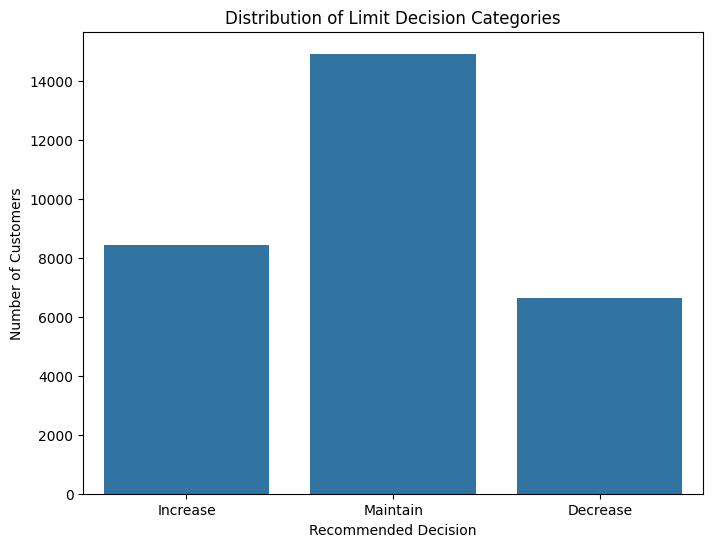

In [10]:
# Define the logic for our new target variable
def assign_limit_decision(row):
    # Rule 1: Decrease Limit (Category 0)
    # If the customer defaulted, their limit should be reviewed for a decrease.
    if row['DEFAULT'] == 1:
        return 'Decrease'

    # Rule 2: Increase Limit (Category 2)
    # Conditions: Did not default, no payment delays in the last 2 months,
    # and their average bill is at least 40% of their credit limit.
    elif (row['PAY_0'] <= 0 and row['PAY_2'] <= 0 and
          (row[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean() / row['LIMIT_BAL']) > 0.4):
        return 'Increase'

    # Rule 3: Maintain Limit (Category 1)
    # All other non-defaulting customers.
    else:
        return 'Maintain'

# Apply the function to create the new target column
df['limit_decision'] = df.apply(assign_limit_decision, axis=1)

print("\n" + "="*50 + "\n")

# Check the distribution of our new target variable
print("Distribution of the new 'limit_decision' target variable:")
print(df['limit_decision'].value_counts())

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='limit_decision', data=df, order=['Increase', 'Maintain', 'Decrease'])
plt.title('Distribution of Limit Decision Categories')
plt.xlabel('Recommended Decision')
plt.ylabel('Number of Customers')
plt.show()

In this step, we will:

Create new, more powerful features from the existing data to capture customer behavior over time.

Drop columns that are no longer needed.\
Separate our data into features (X) and the target (y).\
Define the preprocessing steps for numerical and categorical data using scikit-learn's ColumnTransformer, which is a robust method you used in your previous project.\


In [11]:
# Define categorical and numerical features based on the data dictionary
# Note: The 'PAY_X' columns are technically ordinal but are often treated as numerical in modeling.
# We will start by defining them based on their primary data type.

# Identify columns that are categorical
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE','PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','limit_decision']

# Identify columns that are numerical
numerical_features = [
    'LIMIT_BAL', 'AGE',
    
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

print("--- Feature Lists ---")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"\nNumerical Features ({len(numerical_features)}): {numerical_features}")

--- Feature Lists ---
Categorical Features (10): ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'limit_decision']

Numerical Features (14): ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


**Step 3: Exploratory Data Analysis (EDA) - Univariate Analysis**

In this step, we will analyze individual features to understand their distributions, central tendencies, and spreads. This is crucial for identifying patterns, anomalies, and potential data quality issues.

We will focus on the univariate analysis of our numerical features first.

**1. Credit Limit (LIMIT_BAL)**

This plot shows the distribution of credit limits. We can see if the limits are concentrated in a specific range or if there is a wide variation. The box plot will help us identify the median limit and any potential outliers.

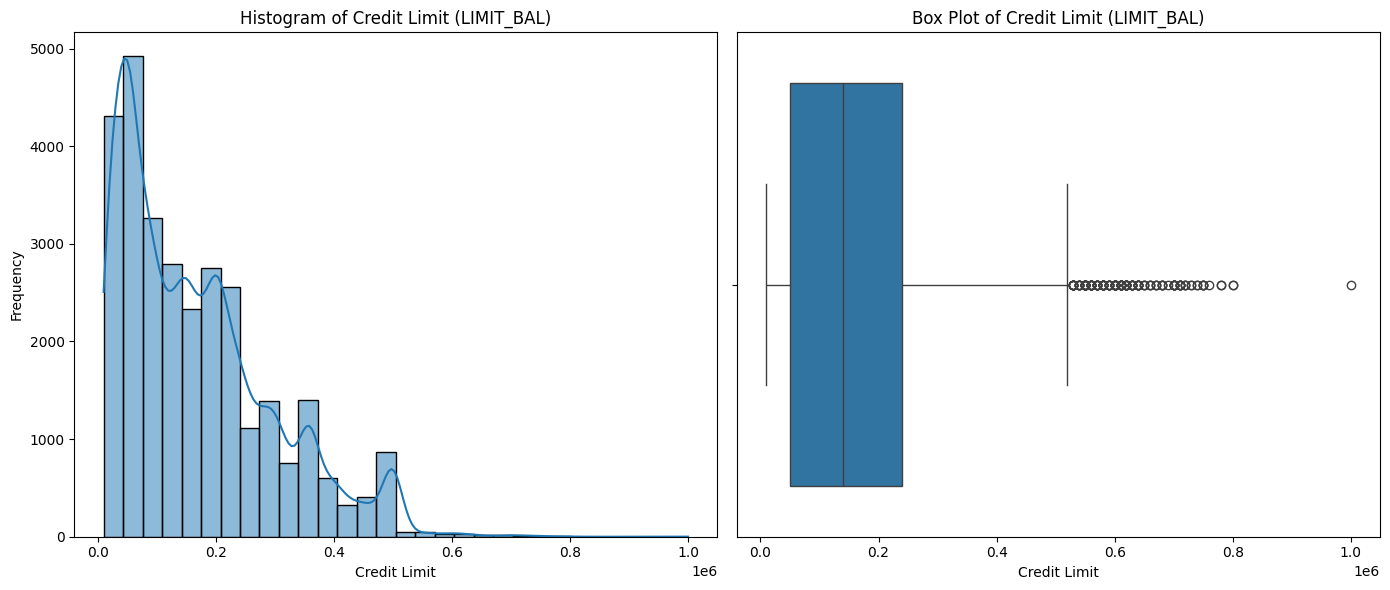

In [12]:
# Plotting for LIMIT_BAL
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['LIMIT_BAL'], kde=True, bins=30)
plt.title('Histogram of Credit Limit (LIMIT_BAL)')
plt.xlabel('Credit Limit')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['LIMIT_BAL'])
plt.title('Box Plot of Credit Limit (LIMIT_BAL)')
plt.xlabel('Credit Limit')

plt.tight_layout()
plt.show()

**2. Age**

Here, we examine the age distribution of the clients. This can reveal the primary age group of the bank's customers and whether certain age groups are more common.

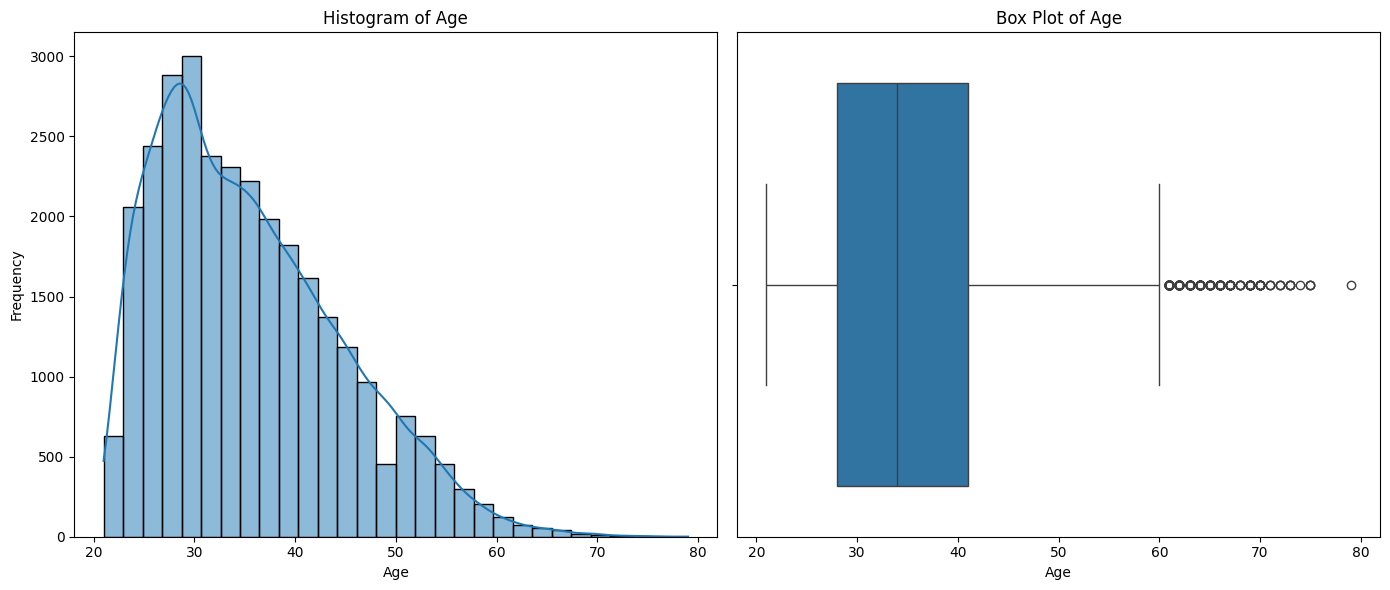

In [13]:
# Plotting for AGE
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['AGE'], kde=True, bins=30)
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Box Plot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['AGE'])
plt.title('Box Plot of Age')
plt.xlabel('Age')

plt.tight_layout()
plt.show()

**3. Bill Statement Amounts (BILL_AMT1 to BILL_AMT6)**

These plots show the distribution of bill amounts over the last six months. This helps us understand the spending habits of the clients. We can see if the bill amounts are generally high or low and identify any extreme values.

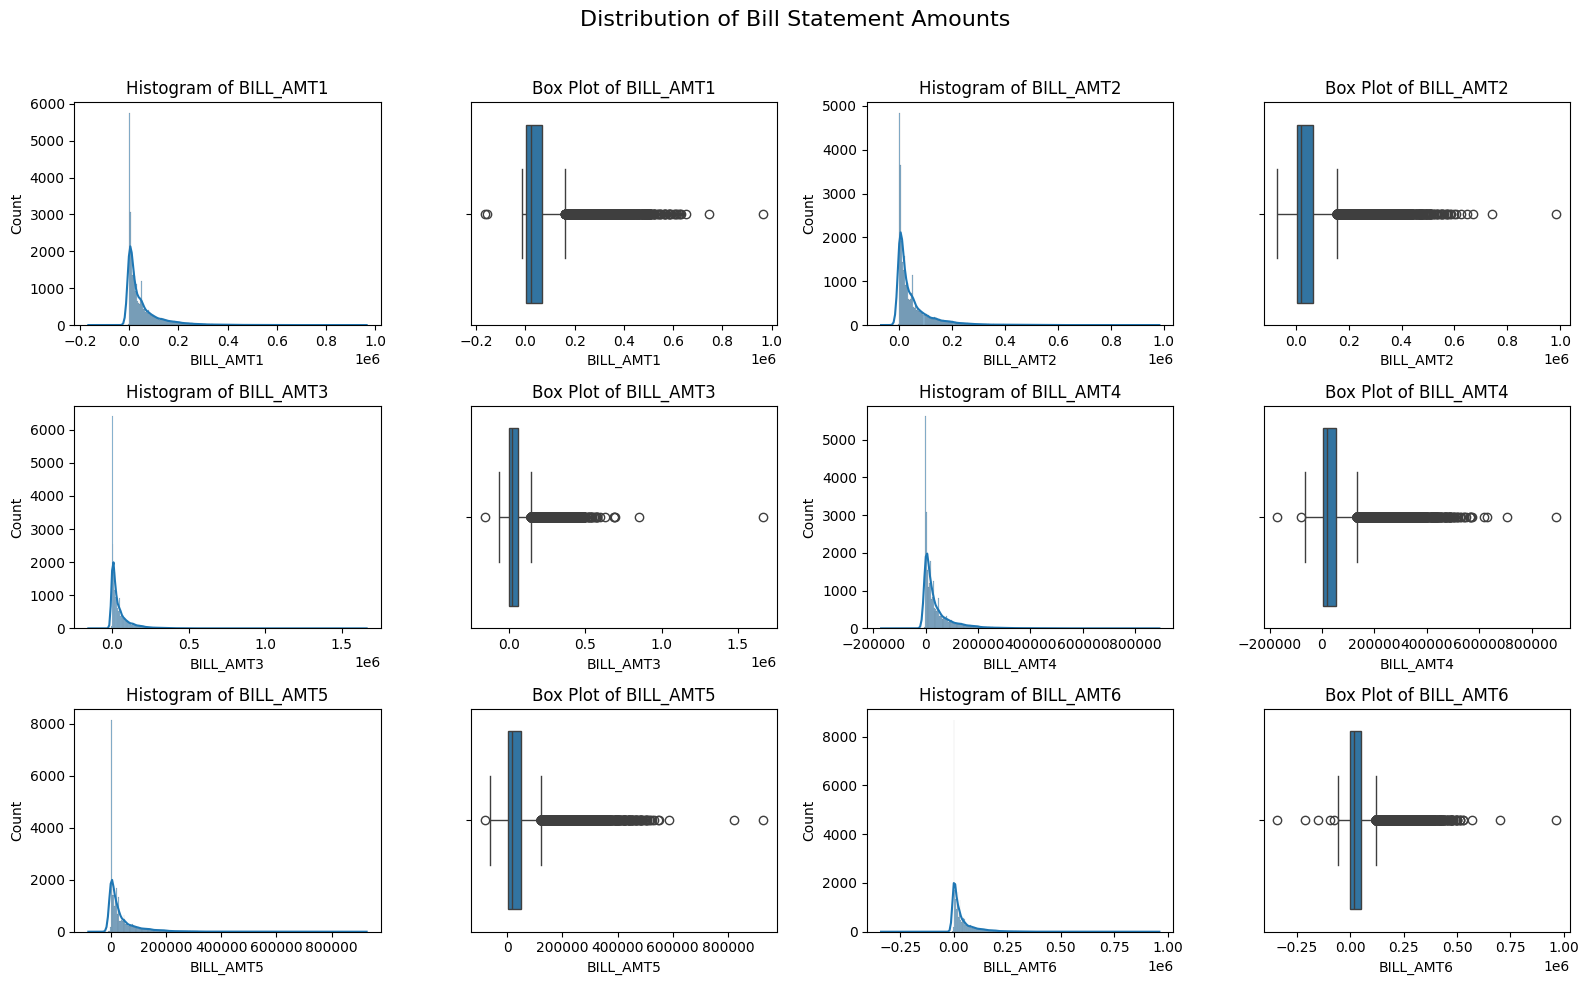

In [14]:
# Plotting for Bill Amounts
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

plt.figure(figsize=(16, 10))
plt.suptitle('Distribution of Bill Statement Amounts', fontsize=16)

for i, col in enumerate(bill_amt_cols):
    # Histogram
    plt.subplot(3, 4, 2*i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    
    # Box Plot
    plt.subplot(3, 4, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**4. Previous Payment Amounts (PAY_AMT1 to PAY_AMT6)**

These plots show the distribution of the amounts paid by clients. This is critical for understanding their payment behavior. We can observe if clients tend to pay small amounts, pay in full, or if there are large variations in payments. The heavy concentration near zero suggests many clients make smaller payments compared to their bills.

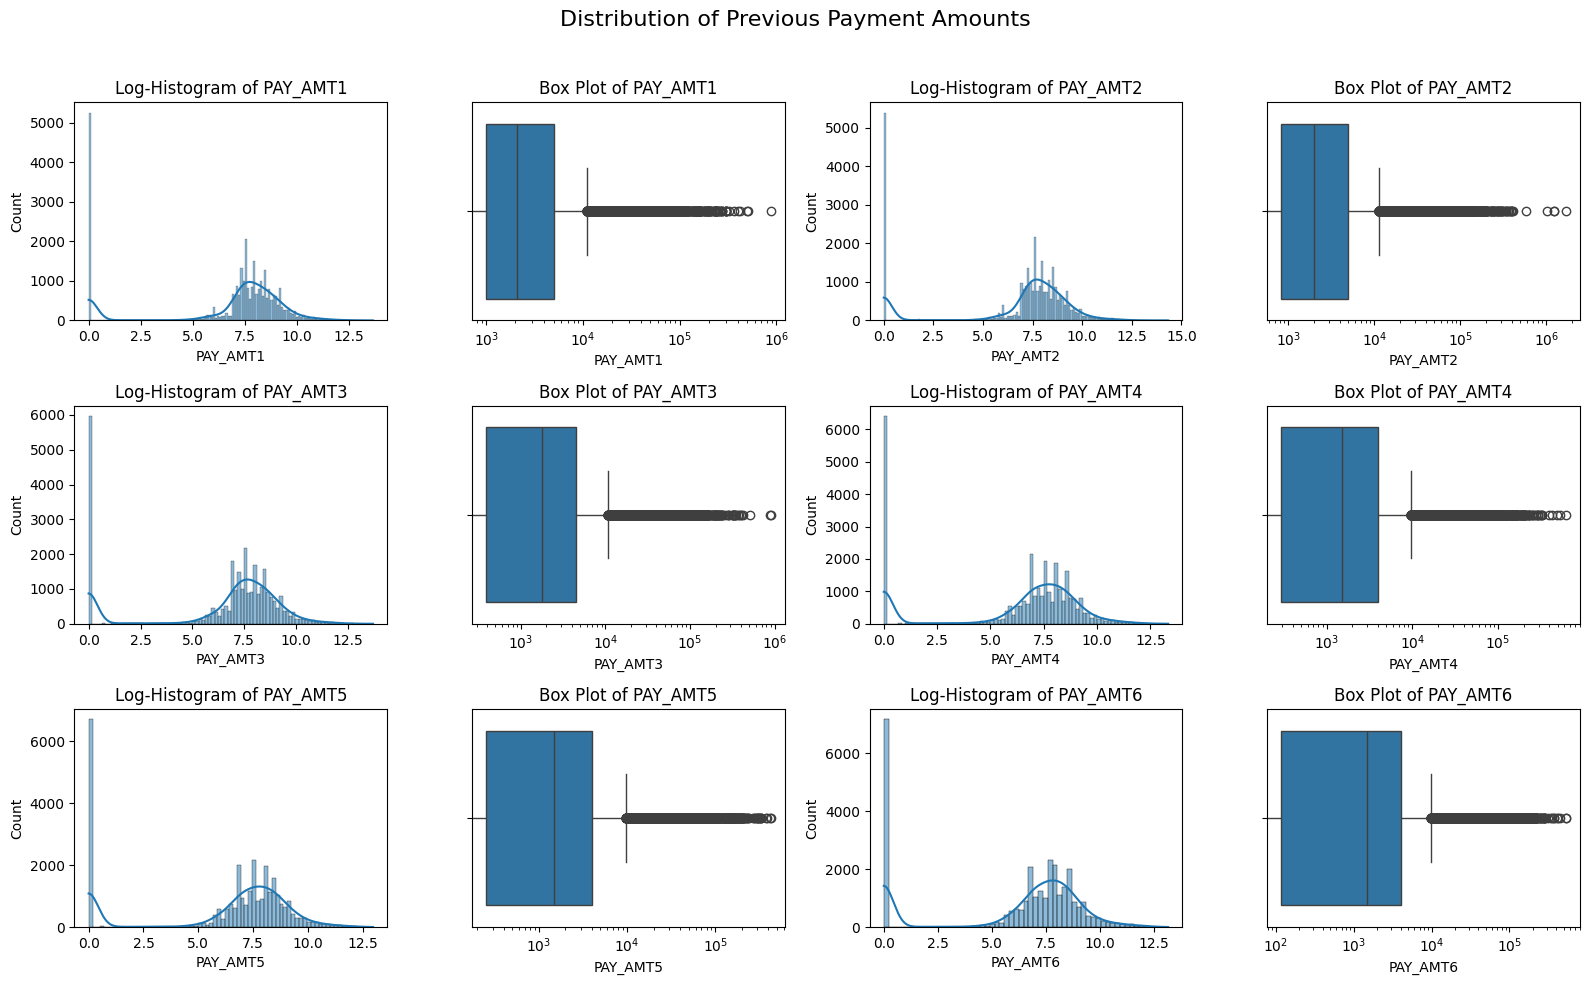

In [15]:
# Plotting for Payment Amounts
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

plt.figure(figsize=(16, 10))
plt.suptitle('Distribution of Previous Payment Amounts', fontsize=16)

for i, col in enumerate(pay_amt_cols):
    # We'll use a log scale for the histogram to better visualize the distribution due to outliers
    # We add 1 to avoid log(0) issues
    
    # Histogram
    plt.subplot(3, 4, 2*i + 1)
    sns.histplot(np.log1p(df[col]), kde=True)
    plt.title(f'Log-Histogram of {col}')
    
    # Box Plot
    plt.subplot(3, 4, 2*i + 2)
    sns.boxplot(x=df[col])
    plt.title(f'Box Plot of {col}')
    # Using a log scale for the x-axis of the boxplot to handle wide range of values
    plt.xscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**5. KDE Plots for All Numerical Features**

This plot shows the Kernel Density Estimate for all numerical features, including the ones we engineered. This gives a smooth estimate of the probability density function for each feature.

Engineered features not found, creating them now...
Engineered features created.


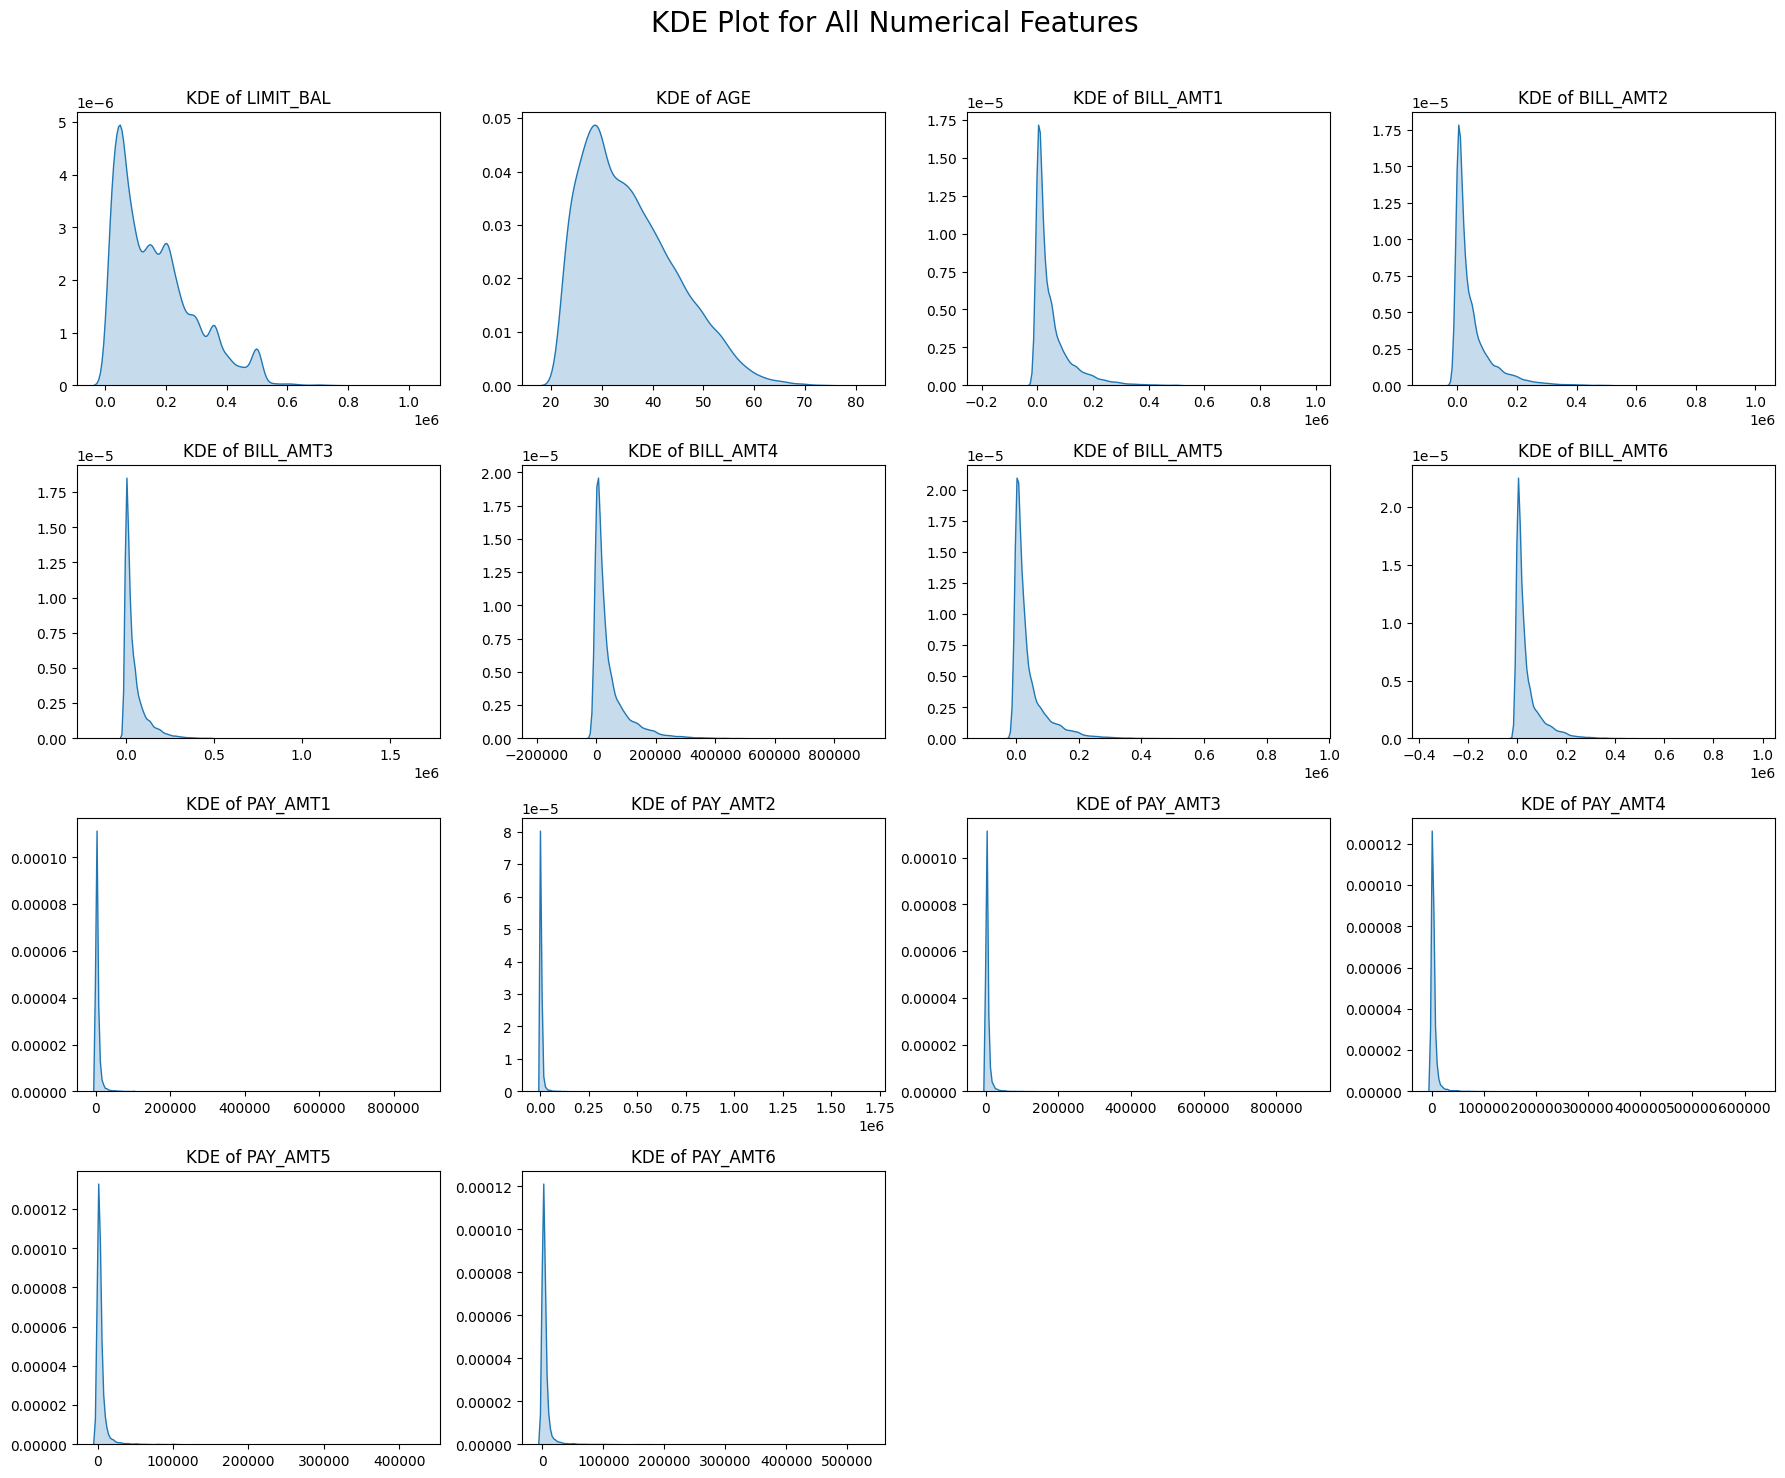

In [16]:
# --- KDE Plots for All Numerical Features ---

# We will use the comprehensive list of numerical features, including engineered ones.
# Note: Engineered features must be created before running this cell.
all_num_features = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

# Check if engineered features exist, if not, create them
if 'AVG_UTILIZATION_3M' not in df.columns:
    print("Engineered features not found, creating them now...")
    # 1. Average Credit Utilization
    df['AVG_UTILIZATION_3M'] = df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) / df['LIMIT_BAL']
    # 2. Average Payment Ratio
    epsilon = 1e-6
    df['AVG_PAY_RATIO_3M'] = df[['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3']].mean(axis=1) / (df[['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3']].mean(axis=1) + epsilon)
    # 3. Number of late payments
    pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    df['LATE_PAYMENT_COUNT'] = (df[pay_cols] > 0).sum(axis=1)
    print("Engineered features created.")


plt.figure(figsize=(18, 22))
plt.suptitle('KDE Plot for All Numerical Features', fontsize=20)

for i, col in enumerate(all_num_features):
    plt.subplot(6, 4, i + 1)
    sns.kdeplot(df[col], fill=True)
    plt.title(f'KDE of {col}')
    plt.xlabel('')
    plt.ylabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**6. Correlation Heatmap for Numerical Features**

This heatmap shows the correlation between all numerical features. It helps us identify multicollinearity, where features are highly correlated with each other. This is important because highly correlated features can sometimes be redundant. We look for strong positive (dark red) or negative (dark blue) correlations.

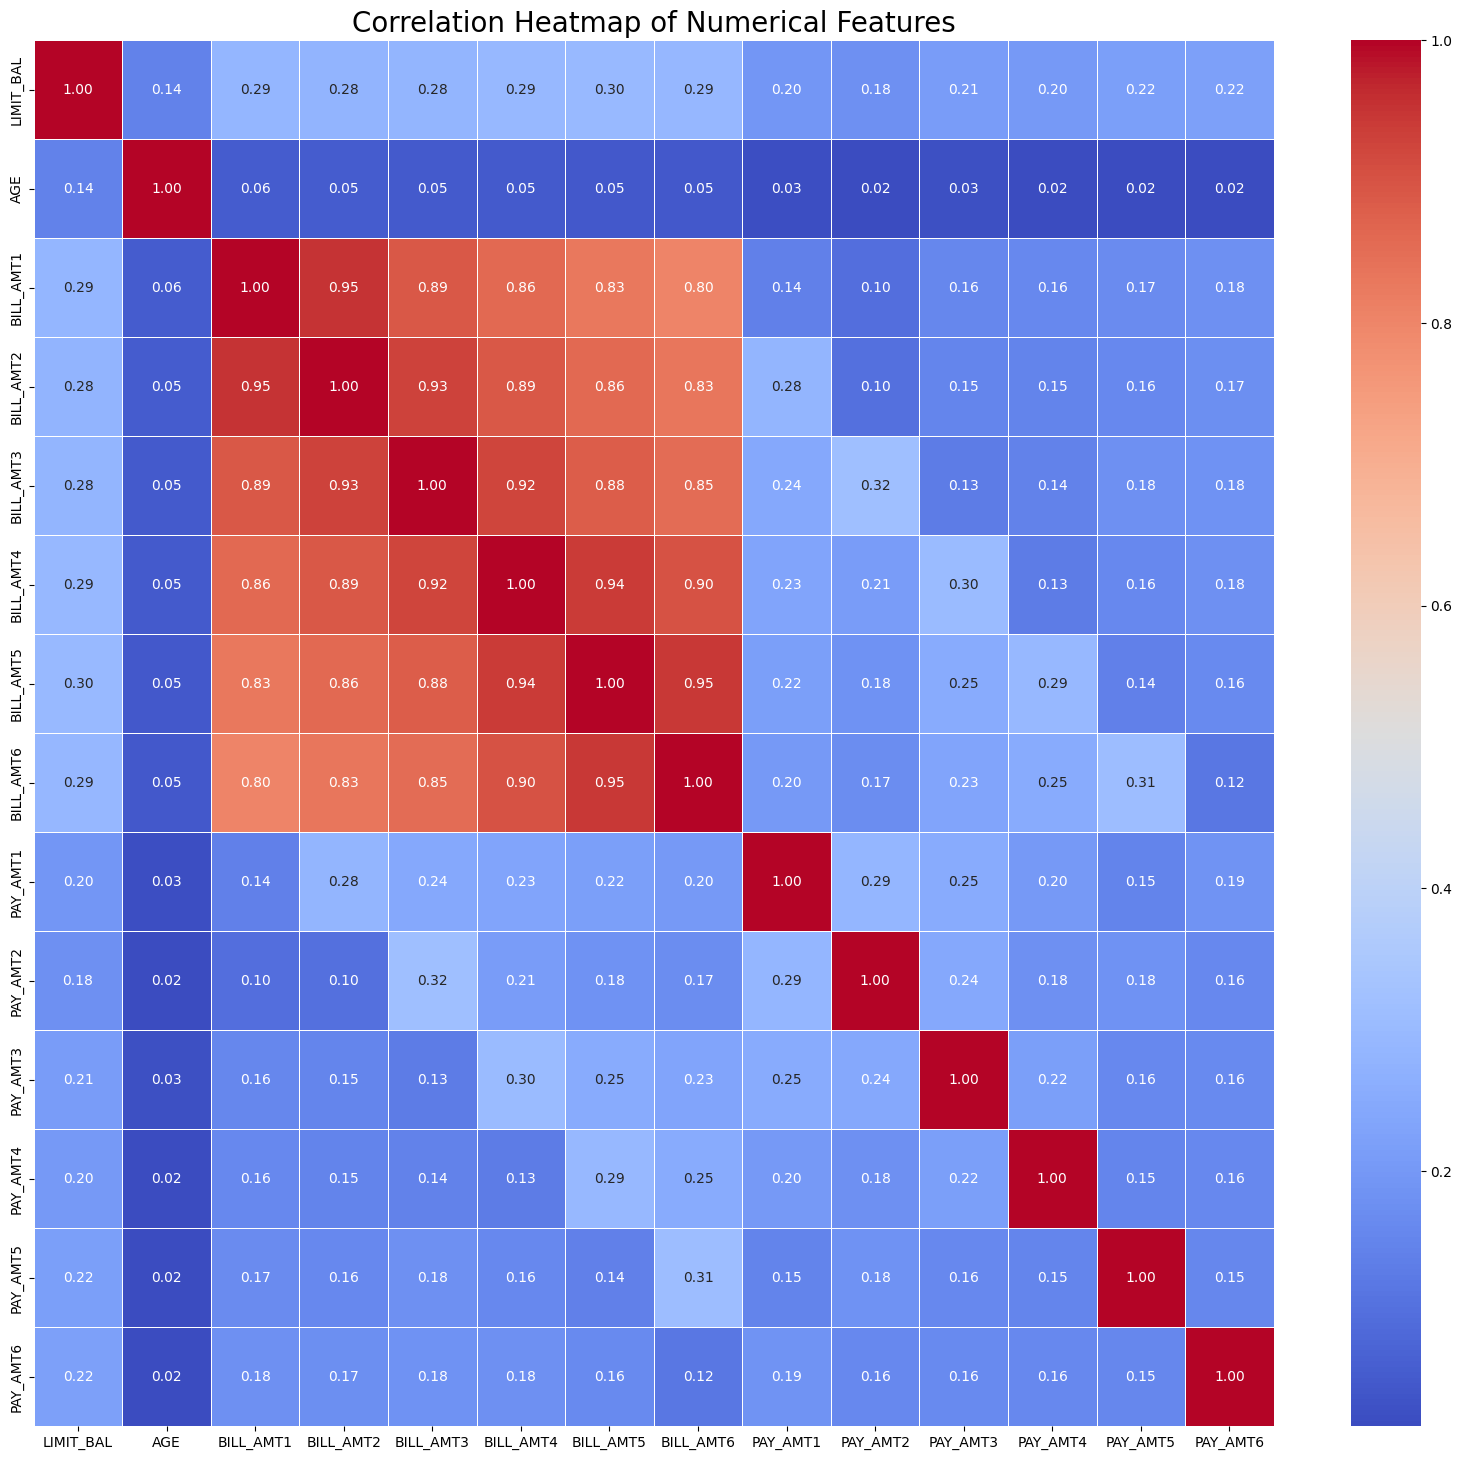

In [17]:
# --- Correlation Heatmap for Numerical Features ---

# We will use the same list of all numerical features
# Note: This requires the engineered features to be present in the DataFrame

# Calculate the correlation matrix
corr_matrix = df[all_num_features].corr()

# Plot the heatmap
plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=20)
plt.show()

**Step 3: Exploratory Data Analysis (EDA) - Bivariate Analysis**

In this step, we will analyze the relationship between our numerical features and the target variable, `limit_decision`. This will help us understand which features might be good predictors for our model. We will use box plots to visualize the distribution of each numerical feature for each of the three decision categories: Increase, Maintain, and Decrease.

--- Generating Bivariate Plots (Numerical vs. Target) ---


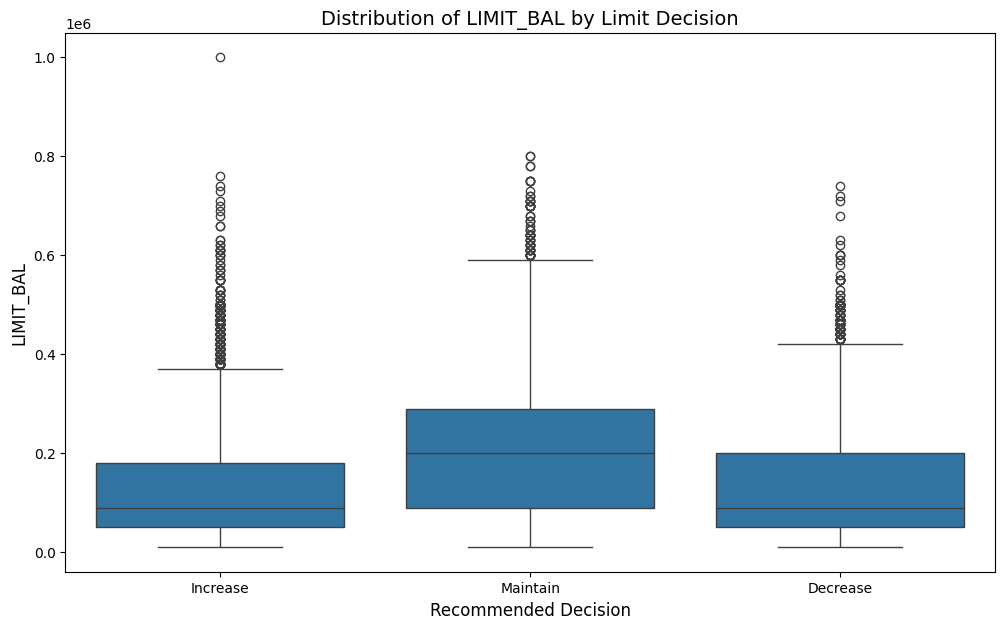

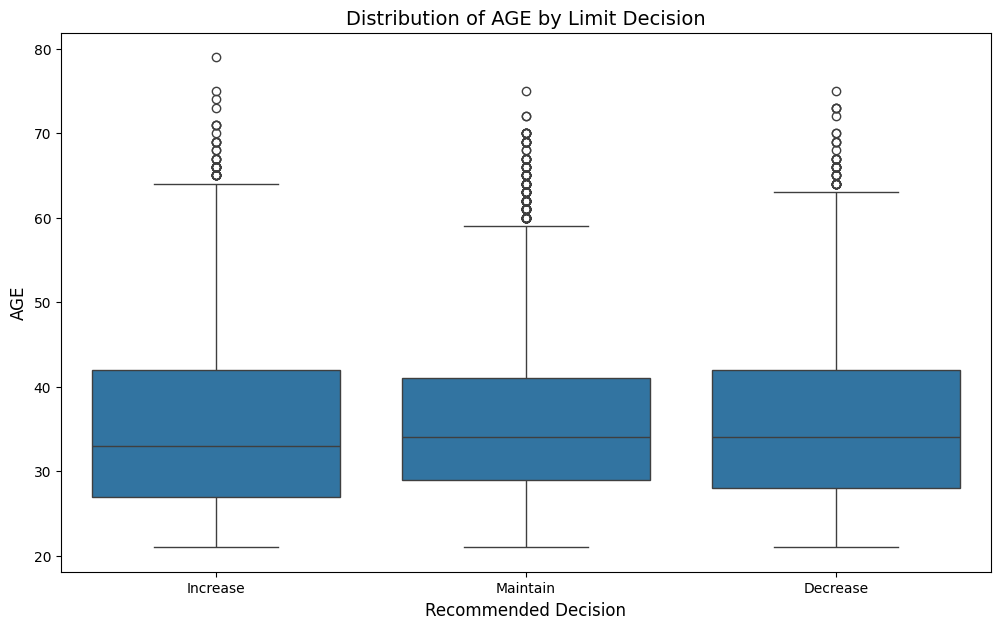

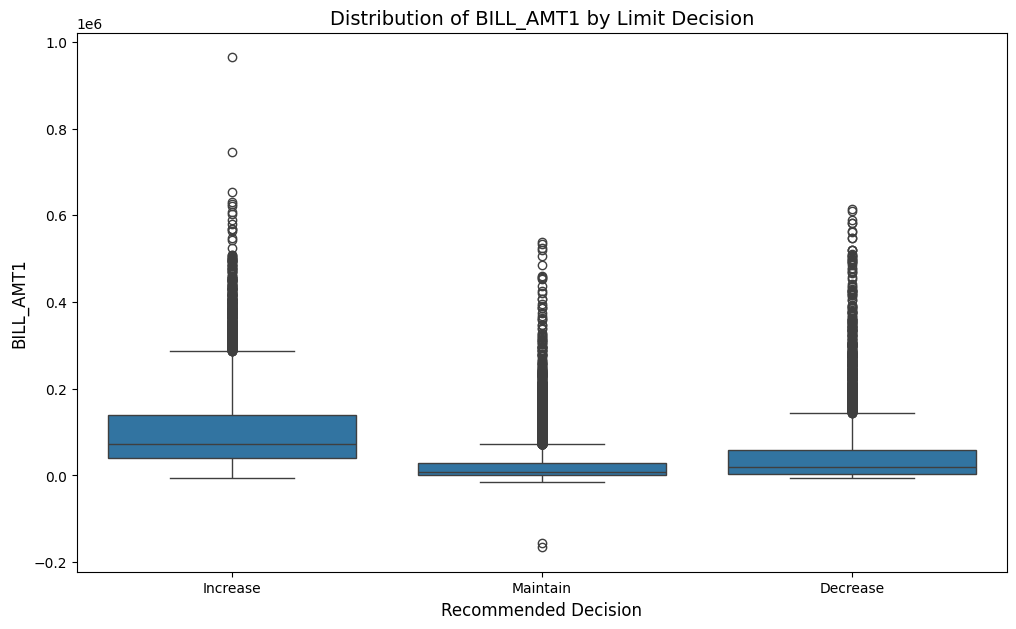

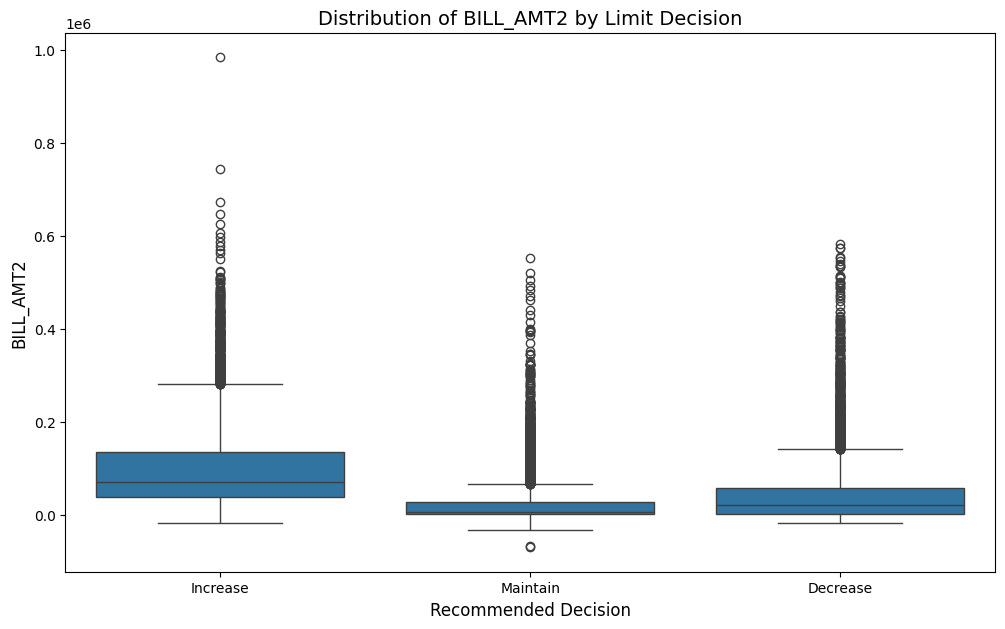

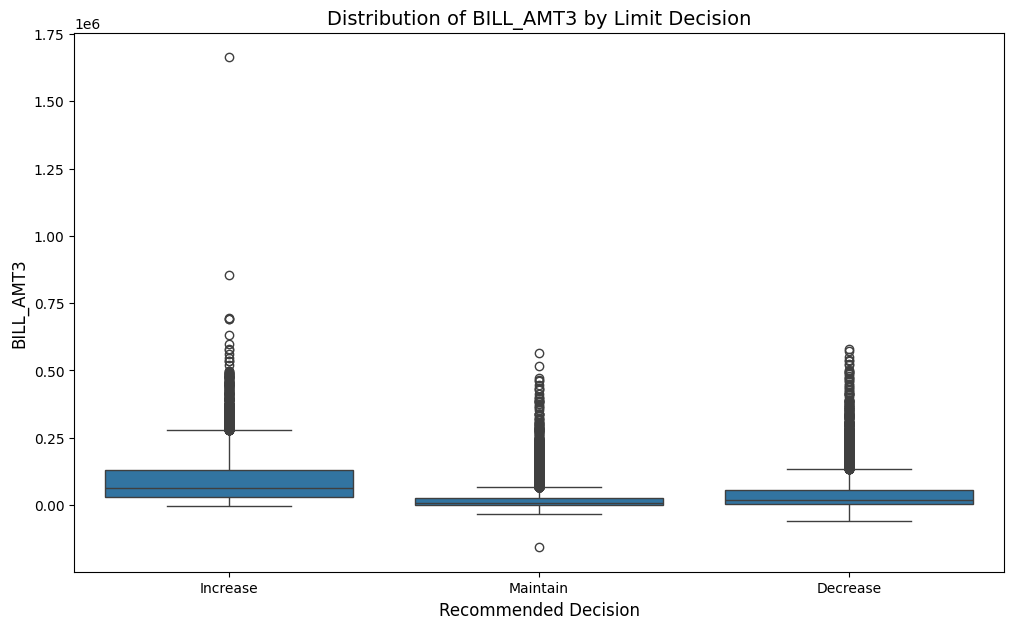

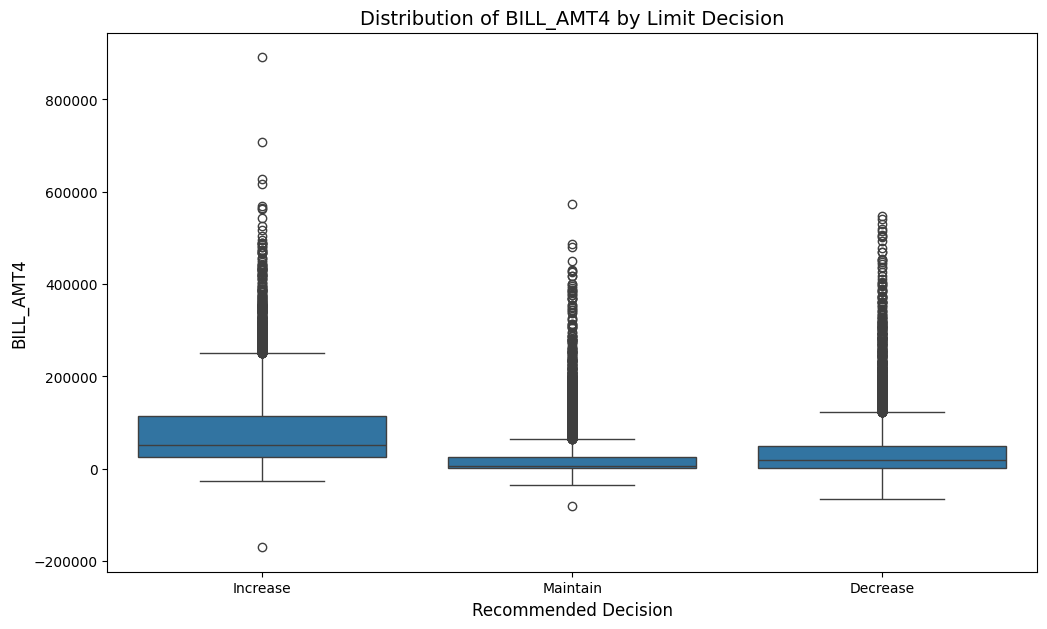

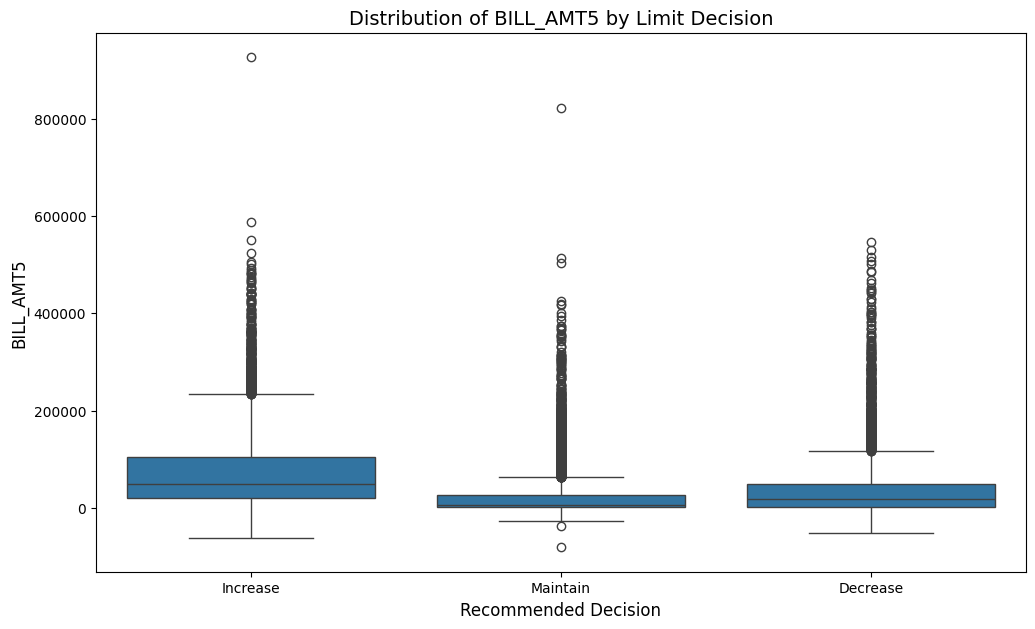

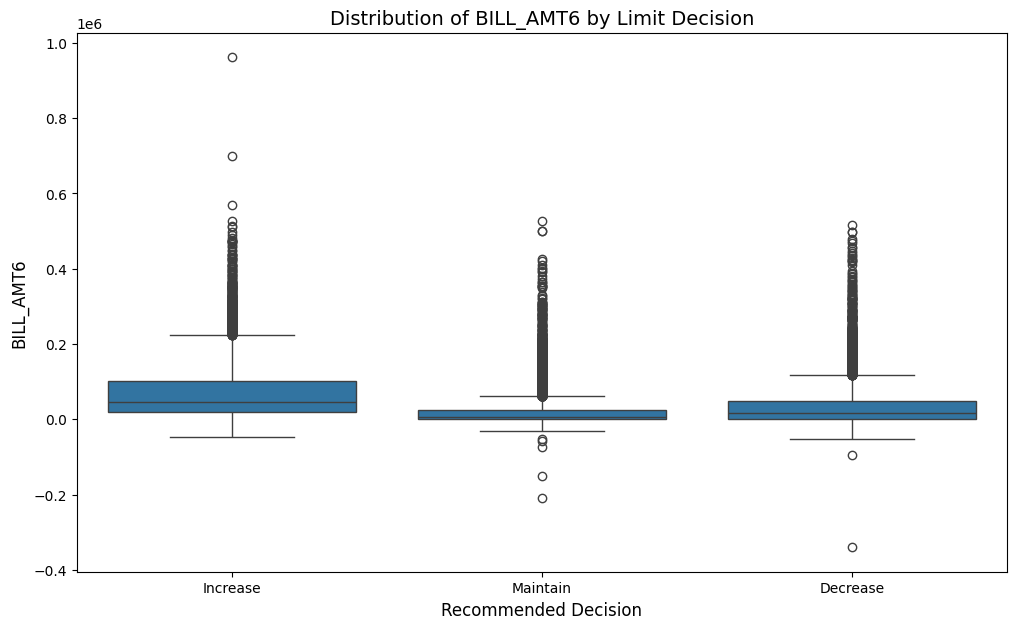

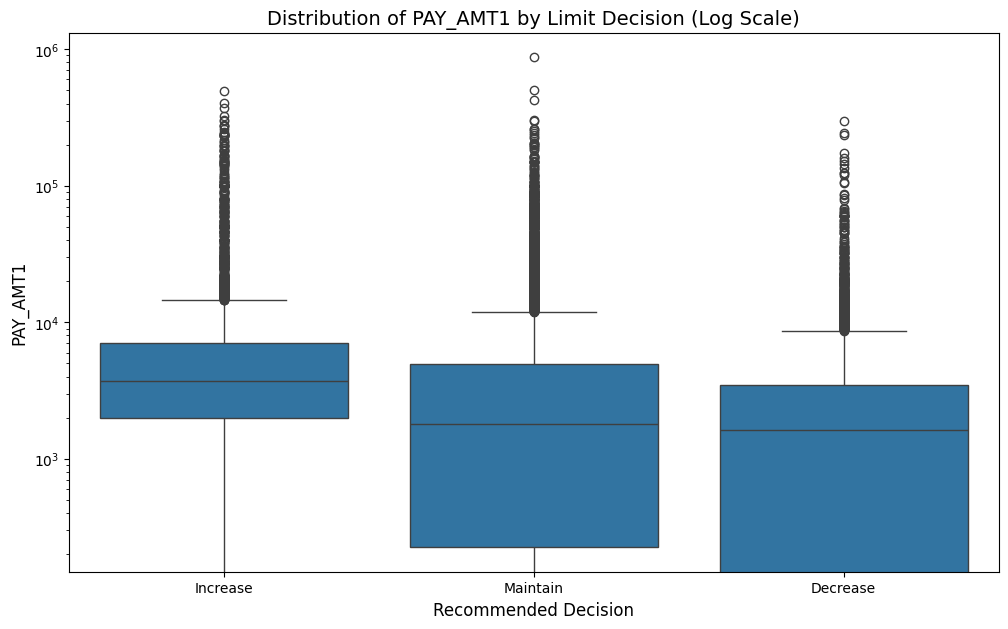

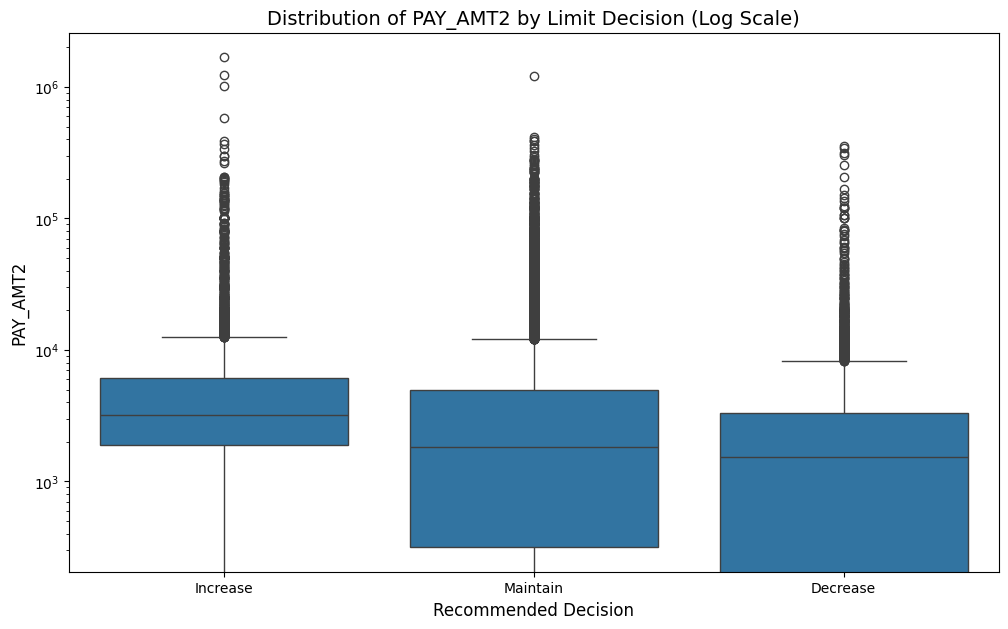

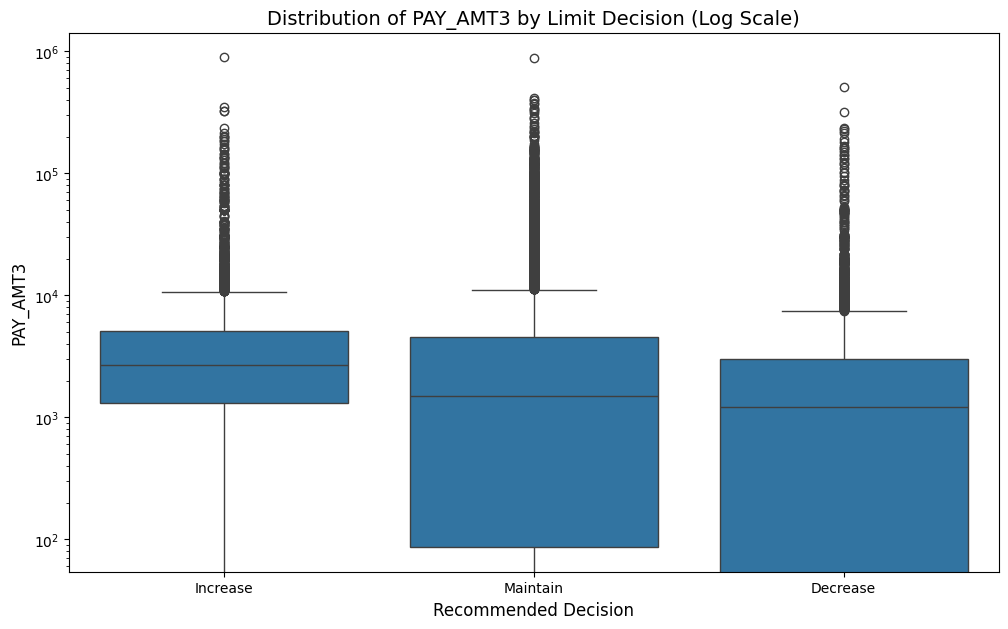

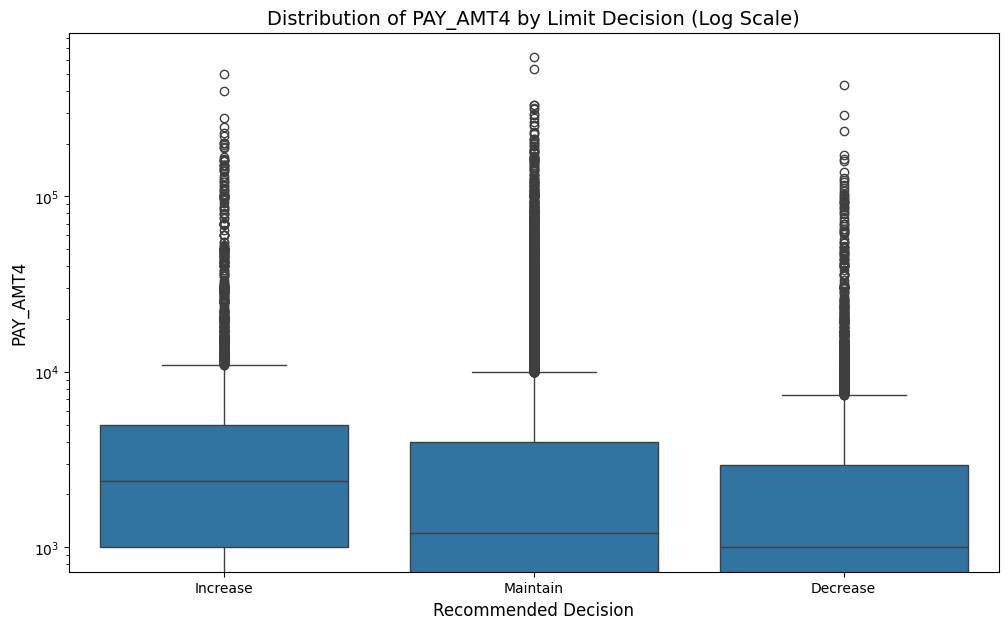

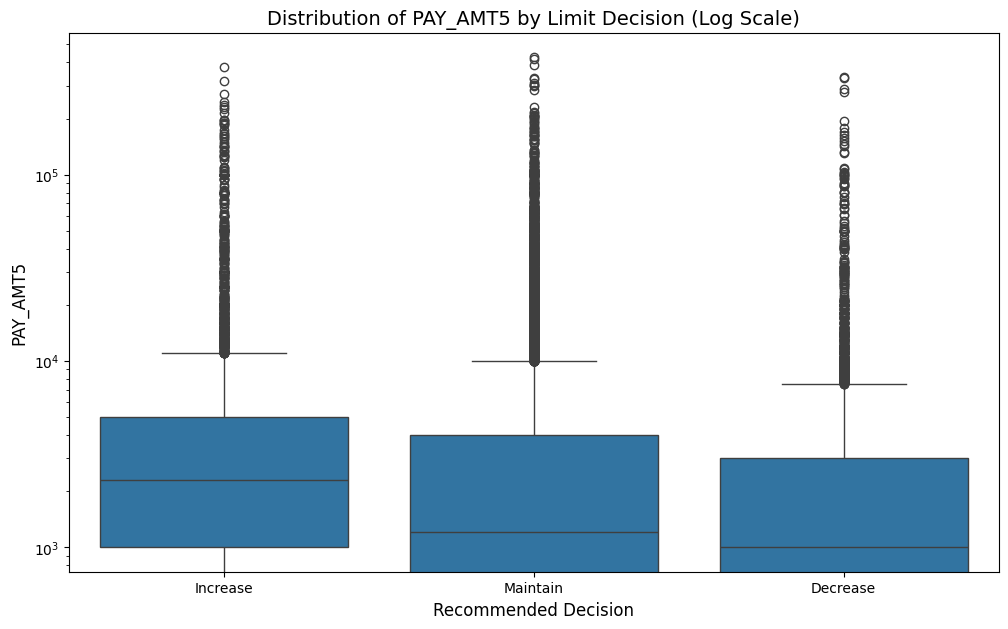

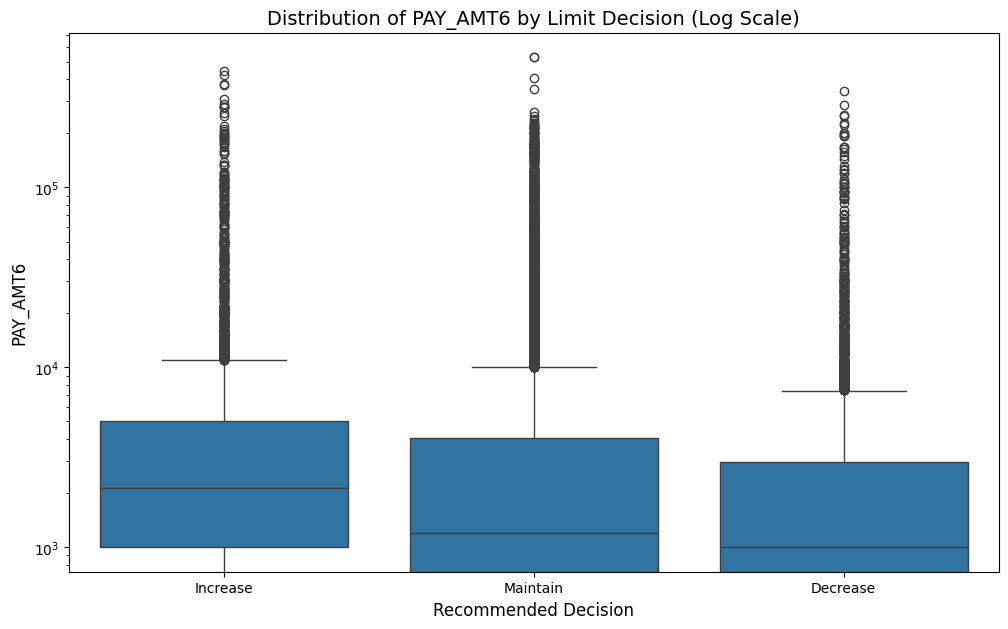


--- Bivariate Analysis Complete ---


In [18]:
# --- Bivariate Analysis: Numerical Features vs. Target Variable ---

# Define the numerical features for this analysis, excluding the 'PAY_X' status columns
# We will include our engineered features as they are numerical.
numerical_features_for_bivariate = [
    'LIMIT_BAL', 'AGE',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
    
]

# Set the order for the target variable categories
decision_order = ['Increase', 'Maintain', 'Decrease']

print("--- Generating Bivariate Plots (Numerical vs. Target) ---")

for feature in numerical_features_for_bivariate:
    plt.figure(figsize=(12, 7))
    
    # Use a box plot to show the distribution for each category
    sns.boxplot(x='limit_decision', y=feature, data=df, order=decision_order)
    
    plt.title(f'Distribution of {feature} by Limit Decision', fontsize=14)
    plt.xlabel('Recommended Decision', fontsize=12)
    plt.ylabel(feature, fontsize=12)
    
    # For features with a very wide range, a log scale can be helpful
    if df[feature].max() / (df[feature].median() + 1) > 100:
        plt.yscale('log')
        plt.title(f'Distribution of {feature} by Limit Decision (Log Scale)', fontsize=14)

    plt.show()

print("\n--- Bivariate Analysis Complete ---")

**Bivariate Analysis: Categorical Features vs. Target Variable**

Here, we analyze the relationship between our categorical features and the `limit_decision` target variable. These plots show how the recommendations (Increase, Maintain, Decrease) are distributed across different categories like education level, marital status, and payment history. This helps us identify which categories are more likely to be associated with a particular credit limit decision.

--- Generating Bivariate Plots (Categorical vs. Target) ---


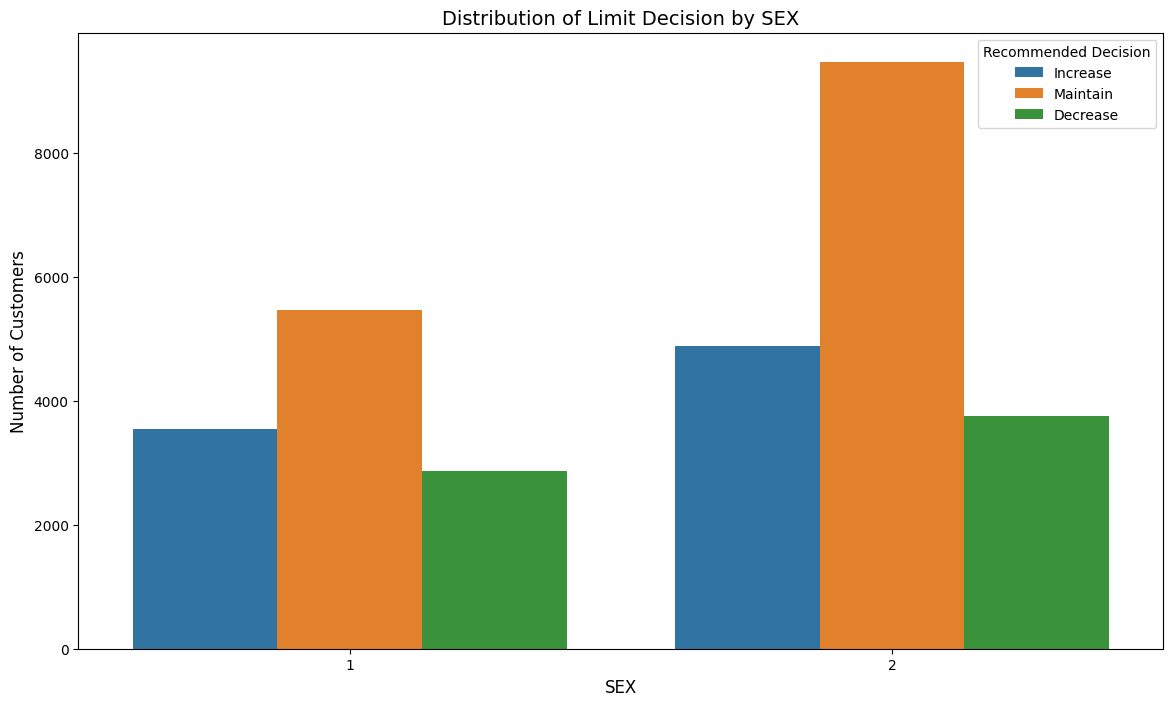

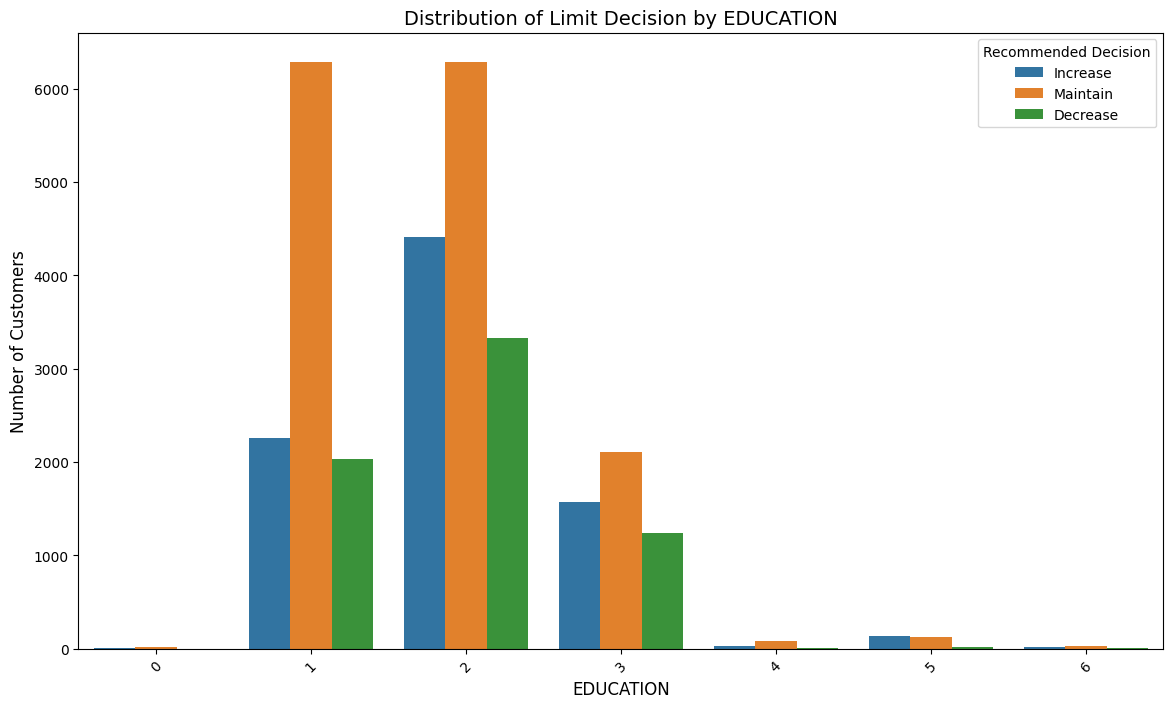

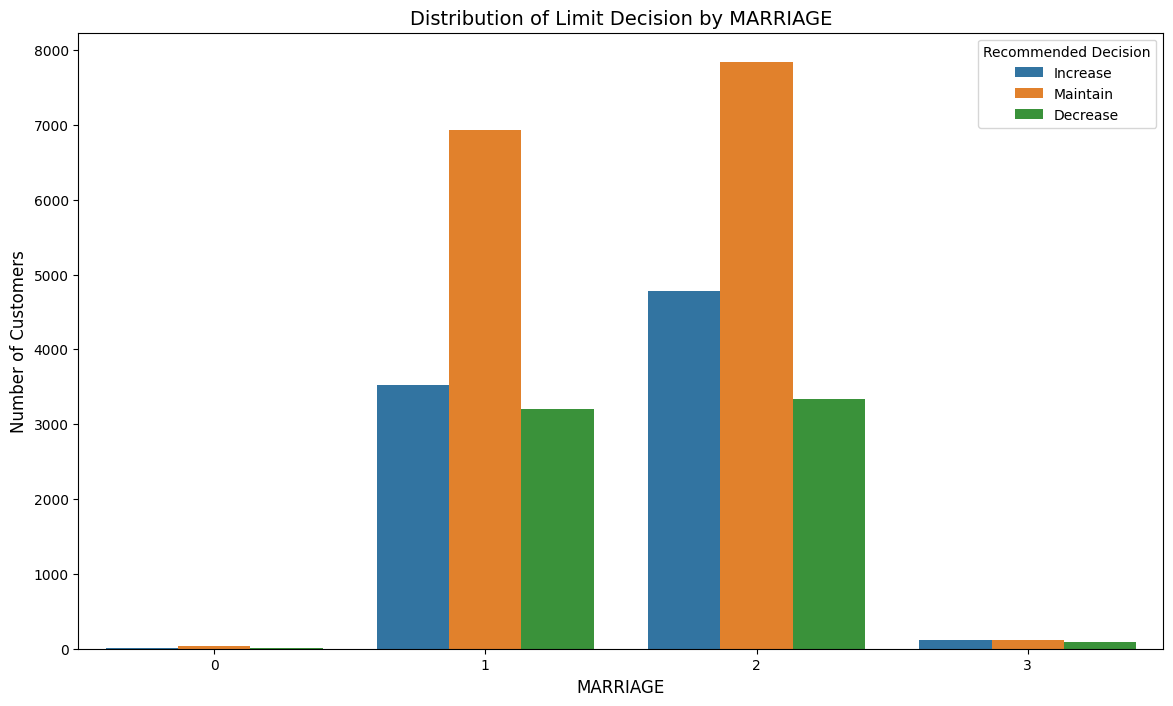

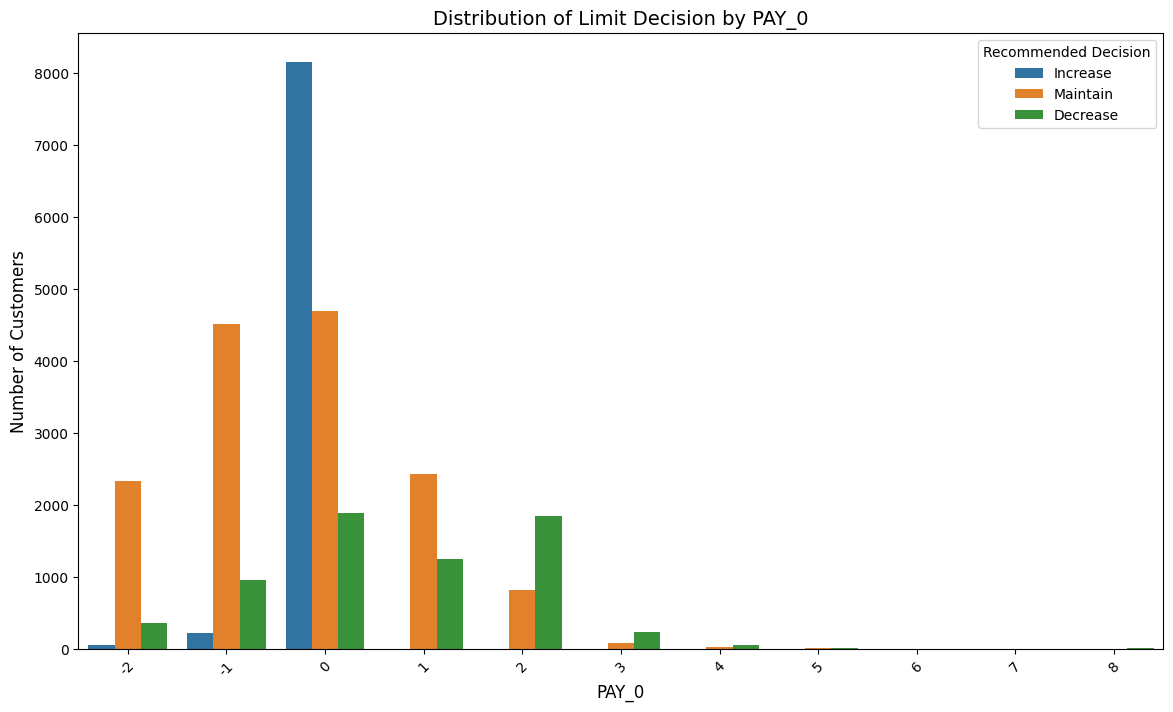

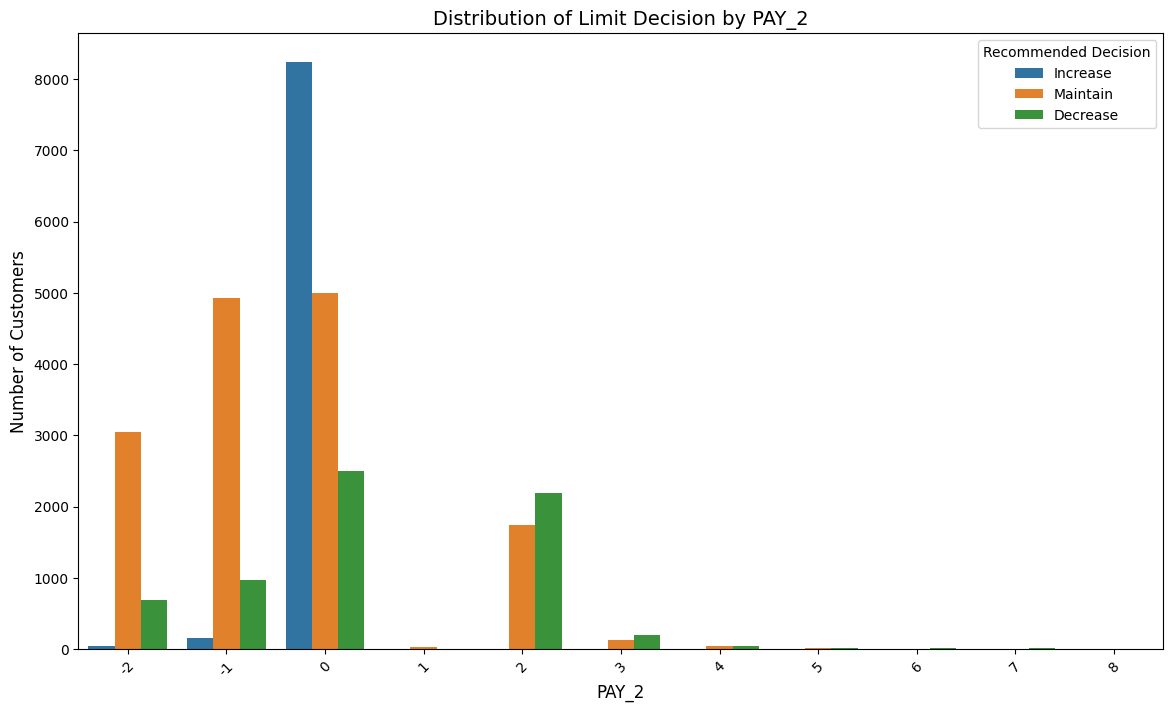

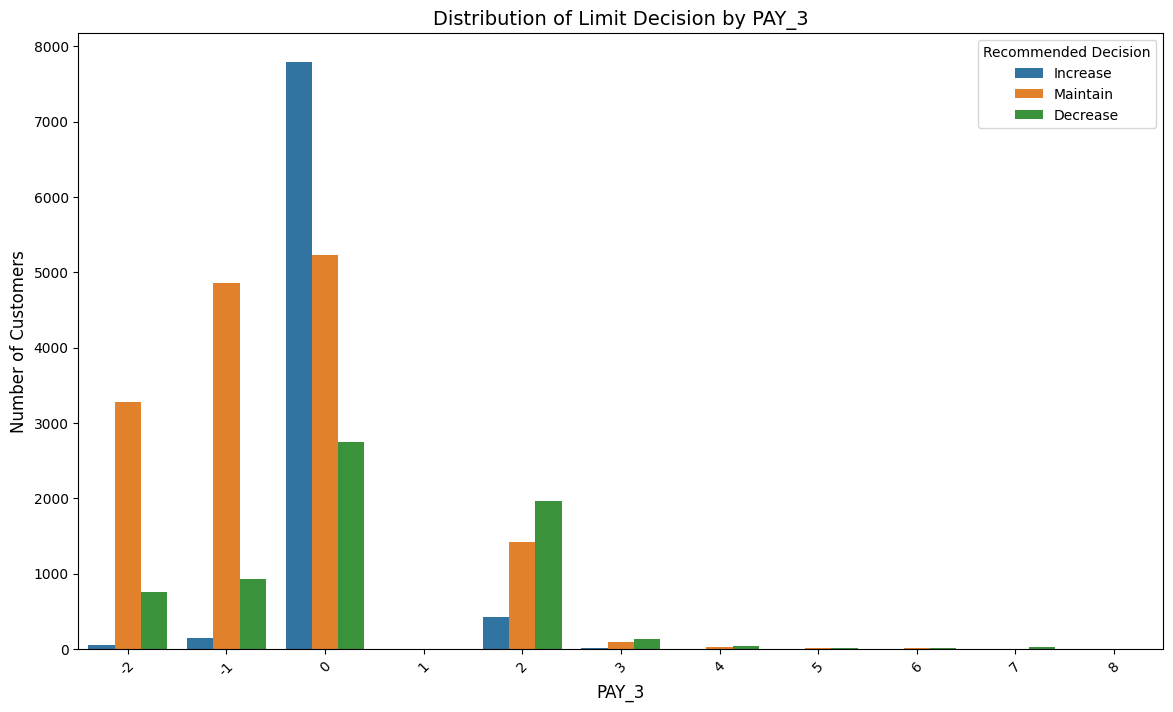

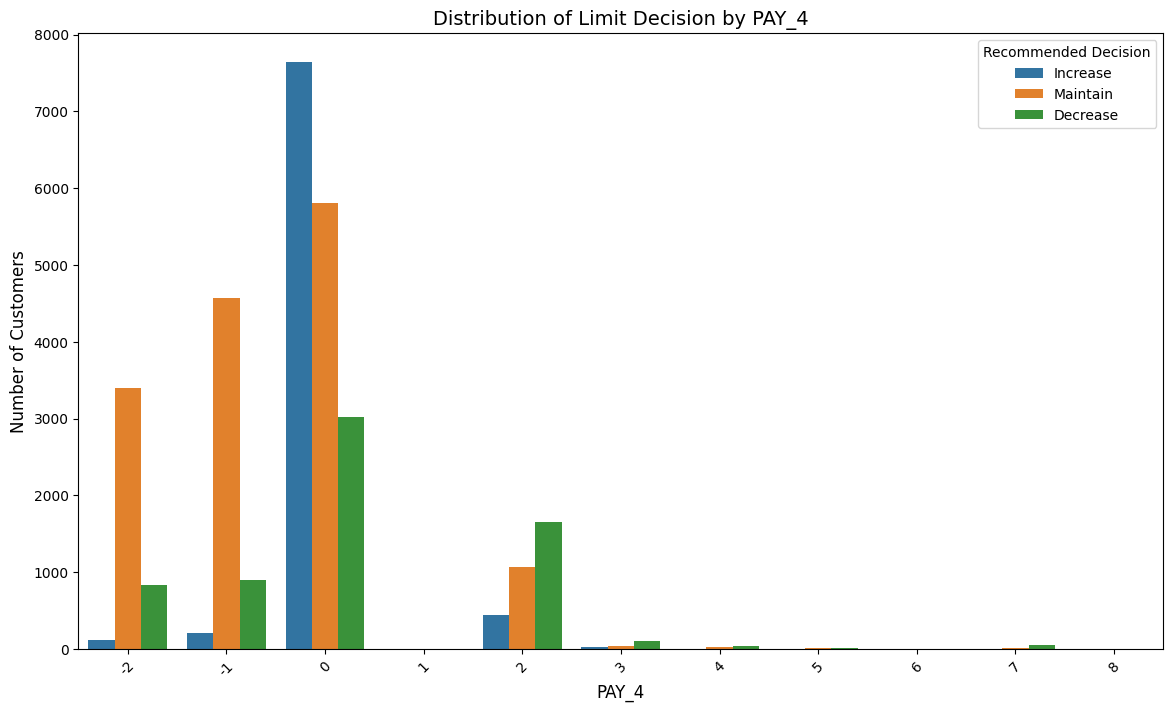

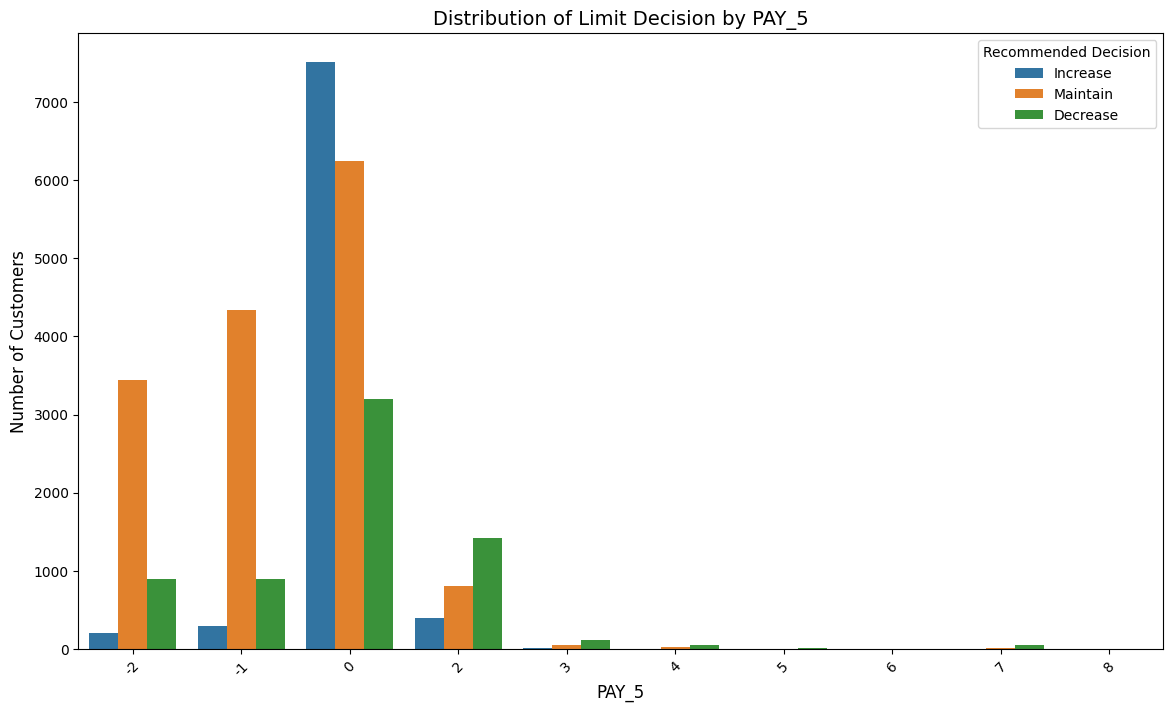

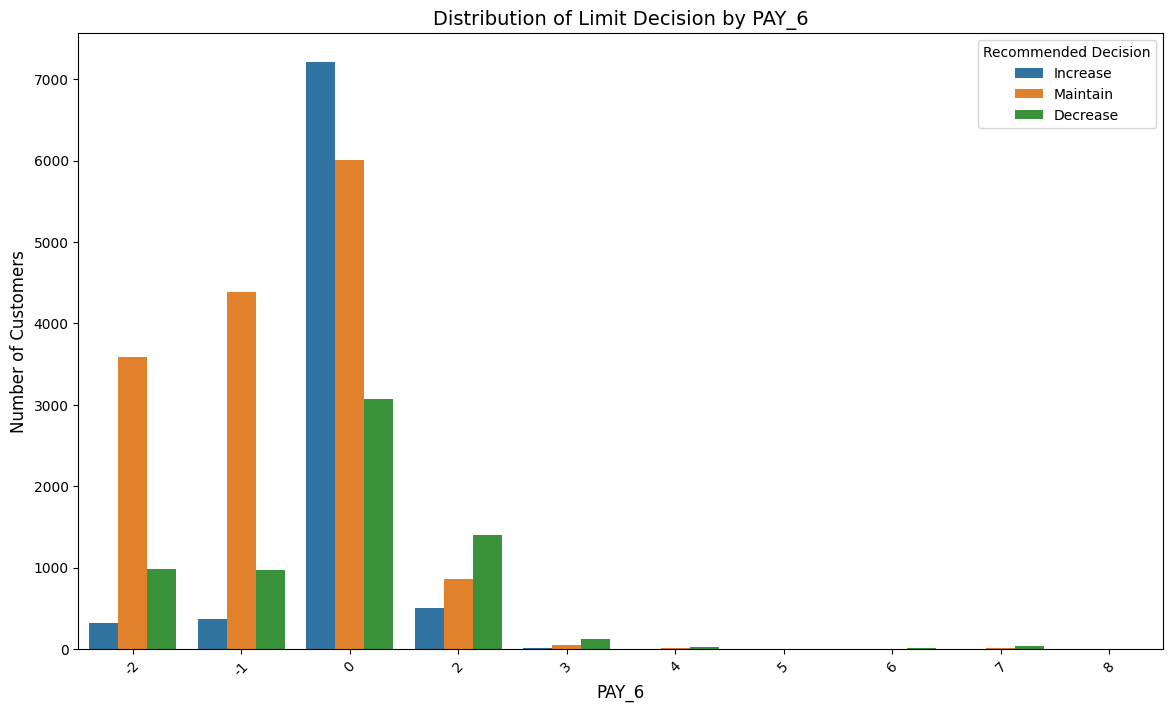


--- Categorical Bivariate Analysis Complete ---


In [19]:
# --- Bivariate Analysis: Categorical Features vs. Target Variable ---

# Define the categorical features for this analysis
# Includes the original categorical features and the payment status columns
categorical_features_for_bivariate = [
    'SEX', 'EDUCATION', 'MARRIAGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

# Set the order for the target variable categories
decision_order = ['Increase', 'Maintain', 'Decrease']

print("--- Generating Bivariate Plots (Categorical vs. Target) ---")

for feature in categorical_features_for_bivariate:
    plt.figure(figsize=(14, 8))
    
    # Use a count plot with hue to show the relationship
    sns.countplot(x=feature, hue='limit_decision', data=df, order=sorted(df[feature].unique()), hue_order=decision_order)
    
    plt.title(f'Distribution of Limit Decision by {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Number of Customers', fontsize=12)
    plt.legend(title='Recommended Decision')
    
    # Rotate x-axis labels if they are crowded
    if len(df[feature].unique()) > 5:
        plt.xticks(rotation=45)
        
    plt.show()

print("\n--- Categorical Bivariate Analysis Complete ---")

**EDA Summary and Feature Elimination Candidates**

Based on the univariate, bivariate, and correlation plots above, we can make some initial decisions about which features to potentially eliminate before the final modeling stage.

**1. Highly Correlated Numerical Features:**

*   **Observation**: The **Correlation Heatmap** clearly shows that the `BILL_AMT` columns (`BILL_AMT1` through `BILL_AMT6`) are extremely correlated with each other (correlation coefficients are mostly > 0.9). This is a strong sign of multicollinearity.
*   **Reason for Elimination**: Including highly correlated features is redundant. They provide similar information to the model, which can lead to unstable coefficient estimates in linear models and can make feature importance less reliable in tree-based models.
*   **Recommendation**: We should not use all six `BILL_AMT` columns in our final model. The feature selection process later in this notebook correctly addresses this by using VIF (Variance Inflation Factor) to iteratively remove them, keeping only `BILL_AMT1` and `BILL_AMT6`. This is a sound strategy as it retains the most recent bill amount and the oldest one, which might capture some trend information.

**2. Features with Low Predictive Power:**

*   **Observation**:
    *   In the bivariate plot for **`SEX`**, the proportion of 'Increase', 'Maintain', and 'Decrease' decisions is nearly identical for both males and females.
    *   Similarly, the box plots for **`AGE`** show that the distribution of age is very similar across all three decision categories.
*   **Reason for Elimination**: If a feature's distribution does not change much across the different target variable categories, it implies that the feature has low predictive power. It doesn't help the model distinguish between the different outcomes.
*   **Recommendation**: `SEX` and `AGE` are strong candidates for removal. The statistical tests in the "Feature Engineering & Statistical Feature Selection" section (Chi-Square for `SEX` and ANOVA for `AGE`) will provide quantitative evidence to support this decision. Based on the plots, we expect them to be found statistically insignificant.

By removing these features, we can build a simpler, faster, and potentially more robust model that focuses only on the most impactful predictors.

In [20]:
# Remove the highly correlated BILL_AMT columns as identified in the EDA

bill_cols_to_drop = ['BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5','DEFAULT','ID']
df.drop(columns=bill_cols_to_drop, inplace=True)

print("Removed redundant BILL_AMT columns.")
print("Remaining columns:", df.columns.tolist())

Removed redundant BILL_AMT columns.
Remaining columns: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'limit_decision', 'AVG_UTILIZATION_3M', 'AVG_PAY_RATIO_3M', 'LATE_PAYMENT_COUNT']


In [21]:
# Identify categorical and numerical features from the remaining columns
categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

numerical_features = [
    'LIMIT_BAL', 'AGE', 
    'BILL_AMT1', 'BILL_AMT6', 
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

print("--- Updated Feature Lists ---")
print(f"Categorical Features ({len(categorical_features)}): {categorical_features}")
print(f"Numerical Features ({len(numerical_features)}): {numerical_features}")

--- Updated Feature Lists ---
Categorical Features (9): ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Numerical Features (10): ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


**Step 4: Statistical Feature Selection**

Now we will perform statistical tests to validate our observations from the EDA and select the most predictive features for our model.

**1. Chi-Square Test for Categorical Features**

We will use the Chi-Square test to check for significant associations between our categorical features and the `limit_decision` target variable. A low p-value (typically <= 0.05) suggests that the feature is a good predictor.

In [22]:
from scipy.stats import chi2_contingency

# --- Chi-Square Test for Categorical Features ---
print("--- Chi-Square Test Results (p-value <= 0.05 is significant) ---")

# Use the list of categorical features we defined earlier
categorical_features_to_test = [
    'SEX', 'EDUCATION', 'MARRIAGE', 
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
]

# This list will hold the features that are statistically significant
significant_cat_features = []

for feature in categorical_features_to_test:
    # Create a contingency table (cross-tabulation)
    contingency_table = pd.crosstab(df[feature], df['limit_decision'])
    
    # Perform the Chi-Square test
    chi2, pval, _, _ = chi2_contingency(contingency_table)
    
    print(f"Feature: {feature}, P-value: {pval:.4f}")
    
    # Check if the p-value is less than or equal to 0.05
    if pval <= 0.05:
        significant_cat_features.append(feature)

print("\n--- Feature Selection Results ---")
print(f"Categorical features kept based on Chi-Square test: {significant_cat_features}")

--- Chi-Square Test Results (p-value <= 0.05 is significant) ---
Feature: SEX, P-value: 0.0000
Feature: EDUCATION, P-value: 0.0000Feature: EDUCATION, P-value: 0.0000
Feature: MARRIAGE, P-value: 0.0000
Feature: PAY_0, P-value: 0.0000

Feature: MARRIAGE, P-value: 0.0000
Feature: PAY_0, P-value: 0.0000
Feature: PAY_2, P-value: 0.0000
Feature: PAY_3, P-value: 0.0000
Feature: PAY_4, P-value: 0.0000
Feature: PAY_5, P-value: 0.0000
Feature: PAY_6, P-value: 0.0000

--- Feature Selection Results ---
Categorical features kept based on Chi-Square test: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
Feature: PAY_2, P-value: 0.0000
Feature: PAY_3, P-value: 0.0000
Feature: PAY_4, P-value: 0.0000
Feature: PAY_5, P-value: 0.0000
Feature: PAY_6, P-value: 0.0000

--- Feature Selection Results ---
Categorical features kept based on Chi-Square test: ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']


**2. ANOVA F-test for Numerical Features**

Next, we will use the ANOVA F-test to determine if there is a significant difference in the means of our numerical features across the different `limit_decision` categories. A low p-value indicates that the feature's mean value is significantly different for at least one of the decision groups, making it a valuable predictor.

In [23]:
from scipy.stats import f_oneway

# --- ANOVA F-test for Numerical Features ---
print("--- ANOVA F-test Results (p-value <= 0.05 is significant) ---")

# Use the list of numerical features we defined earlier
numerical_features_to_test = [
    'LIMIT_BAL', 'AGE', 
    'BILL_AMT1', 'BILL_AMT6', 
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

# This list will hold the features that are statistically significant
significant_num_features = []

# Group the data by the target variable
grouped_by_decision = df.groupby('limit_decision')

for feature in numerical_features_to_test:
    # Create a list of arrays, where each array contains the feature's values for one decision category
    samples = [group[feature].values for name, group in grouped_by_decision]
    
    # Perform the ANOVA F-test
    f_stat, pval = f_oneway(*samples)
    
    print(f"Feature: {feature}, P-value: {pval:.4f}")
    
    # Check if the p-value is less than or equal to 0.05
    if pval <= 0.05:
        significant_num_features.append(feature)

print("\n--- Feature Selection Results ---")
print(f"Numerical features kept based on ANOVA test: {significant_num_features}")

--- ANOVA F-test Results (p-value <= 0.05 is significant) ---

Feature: LIMIT_BAL, P-value: 0.0000
Feature: AGE, P-value: 0.0016
Feature: BILL_AMT1, P-value: 0.0000
Feature: BILL_AMT6, P-value: 0.0000
Feature: PAY_AMT1, P-value: 0.0000
Feature: LIMIT_BAL, P-value: 0.0000
Feature: AGE, P-value: 0.0016
Feature: BILL_AMT1, P-value: 0.0000
Feature: BILL_AMT6, P-value: 0.0000
Feature: PAY_AMT1, P-value: 0.0000
Feature: PAY_AMT2, P-value: 0.0000
Feature: PAY_AMT3, P-value: 0.0000
Feature: PAY_AMT4, P-value: 0.0000
Feature: PAY_AMT5, P-value: 0.0000
Feature: PAY_AMT6, P-value: 0.0000

--- Feature Selection Results ---
Numerical features kept based on ANOVA test: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
Feature: PAY_AMT2, P-value: 0.0000
Feature: PAY_AMT3, P-value: 0.0000
Feature: PAY_AMT4, P-value: 0.0000
Feature: PAY_AMT5, P-value: 0.0000
Feature: PAY_AMT6, P-value: 0.0000

--- Feature Selection Results ---
Numeric

**3. VIF for Multicollinearity**

Finally, we will check for multicollinearity among our remaining numerical features using the Variance Inflation Factor (VIF). VIF measures how much the variance of an estimated regression coefficient is increased because of collinearity.

- A VIF between 1 and 5 is considered moderate.
- A VIF greater than 5 or 10 indicates high multicollinearity.

We will iteratively remove the feature with the highest VIF until all features have a VIF score of less than 6. This ensures that the remaining features are independent of each other.

Yes, absolutely. You've asked a very important question about the correct order of operations.

**You should always calculate VIF *before* applying transformations (like PowerTransformer) and one-hot encoding.**

Here is the correct workflow and the reasoning behind it:

1.  **Identify Multicollinearity on Raw Data (VIF):**
    *   **Why?** VIF is designed to measure the linear relationship between your original numerical features. The goal is to see if one feature can be linearly predicted by others. Applying a non-linear transformation (like the Yeo-Johnson transform) first would change these relationships and could hide or alter the true multicollinearity. We want to select features based on their inherent relationships, not their transformed ones.

2.  **Finalize Feature Lists:**
    *   After running the VIF, you have your final, independent set of numerical features. You also have your list of categorical features.

3.  **Split the Data (Train-Test Split):**
    *   **Why?** This is crucial to prevent data leakage. All fitting (including for transformers and encoders) should only be done on the training data.

4.  **Apply Transformations and Encoding in a Pipeline:**
    *   **Why last?** The `PowerTransformer`, `StandardScaler`, and `OneHotEncoder` are all preprocessing steps that prepare the data for the model. They should be fitted *only* on the training data and then used to transform both the training and test data. This is why we put them inside the `ColumnTransformer` and `Pipeline`.

In short, the sequence is:

**Feature Selection (on raw data) -> Train-Test Split -> Preprocessing (on split data)**

The way we have structured the notebook is correct: we first use ANOVA and VIF to finalize our feature list, and only then do we use the `ColumnTransformer` to apply the transformations and encoding.

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- VIF for Multicollinearity ---
print("--- Iterative VIF Calculation (removing features with VIF > 6) ---")

# Start with the numerical features that passed the ANOVA test
vif_data = df[significant_num_features].copy()

# This is the iterative process
while True:
    # Calculate VIF for all features in the current set
    # We add a constant to the data because VIF is calculated using a regression model
    vif_values = [variance_inflation_factor(vif_data.values, i) for i in range(vif_data.shape[1])]
    max_vif = max(vif_values)
    
    if max_vif > 6:
        max_vif_index = vif_values.index(max_vif)
        removed_feature = vif_data.columns[max_vif_index]
        vif_data = vif_data.drop(columns=[removed_feature])
        print(f"  - Removed '{removed_feature}' (VIF: {max_vif:.2f})")
    else:
        break

final_numerical_features_after_vif = vif_data.columns.tolist()
print(f"\nFinal numerical features after VIF: {final_numerical_features_after_vif}")

print("\n--- VIF Feature Selection Complete ---")

--- Iterative VIF Calculation (removing features with VIF > 6) ---

Final numerical features after VIF: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

--- VIF Feature Selection Complete ---

Final numerical features after VIF: ['LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

--- VIF Feature Selection Complete ---


**Step 5: Final Feature Selection and Preprocessing Pipeline**

Now that we have identified which features are statistically significant, we will create our final feature lists and build a preprocessing pipeline to prepare the data for modeling. This involves applying the correct encoding strategy to each feature type.

### Rationale for Encoding Strategies

1.  **Ordinal Features (`PAY_0` through `PAY_6`):**
    *   **Observation:** These features have a clear, meaningful order where a higher value indicates a longer payment delay. For example, a delay of 2 months is worse than a delay of 1 month.
    *   **Strategy:** We will treat these as **numerical features**. Since their existing numerical values already represent their rank, we do not need a separate `OrdinalEncoder`. The model can learn directly from this inherent order. They will be scaled along with our other numerical features.

2.  **Nominal Features (`SEX`, `EDUCATION`, `MARRIAGE`):**
    *   **Observation:** These features represent distinct groups with no logical or mathematical order. For example, `MARRIAGE` status `1` (married) is not "less than" `2` (single).
    *   **Strategy:** We must use **One-Hot Encoding**. This technique converts each category into a new, separate binary (0 or 1) column. This is critical because it prevents the model from learning a false and misleading ranking between the categories. For instance, it ensures the model doesn't assume that `EDUCATION=3` is somehow mathematically related to `EDUCATION=1`.

3.  **Numerical Features (all others):**
    *   **Strategy:** These will be scaled using `StandardScaler` to ensure they have a mean of 0 and a standard deviation of 1. This helps algorithms that are sensitive to feature scales (like Logistic Regression and SVMs) perform better.

### A Note on Outliers and Data Transformation

You've correctly pointed out that our numerical features have outliers and are not normally distributed. This is a crucial observation, especially since we plan to use models like Logistic Regression, which perform better when features follow a more normal distribution.

**The Problem with Simply Removing Outliers in Economic Data**

You asked a very important question: "this is a economic data and skeness is a reality?". You are absolutely right. In financial and economic datasets, what appears to be a statistical outlier is often a real and important data point. For example, a customer with a very high `LIMIT_BAL` is not an error; they are a high-value client. 

If we were to simply **remove** these data points:
1.  **We lose critical information**: The model would never learn how to handle high-value customers.
2.  **We introduce bias**: The model would be trained on an artificially "average" population and would fail on real-world data that includes high or low extremes.

**The Solution: Transformation Instead of Removal**

The best strategy is not to remove these data points, but to **transform** them. The goal is to reduce the extreme influence of these points while keeping the information they provide. We can do this by applying a mathematical function that makes the distribution more symmetric and Gaussian-like (normal).

For this, we will use the **Yeo-Johnson transform**. It is a powerful technique that works on both positive and negative data and is excellent at stabilizing variance and minimizing skewness. By applying this transform, we make our data more suitable for linear models without deleting valuable information.

I will now update the numerical pipeline to use `PowerTransformer` to apply this transform.

### 1. Define Final Feature Lists

Based on our statistical tests and the encoding rationale, we will now define the final lists of features that will be used to train the model.

In [25]:
# --- Final Feature Lists based on Statistical Tests and Rationale ---

# 1. Nominal features to be One-Hot Encoded
# These have no inherent order.
nominal_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# 2. Ordinal & Numerical features to be transformed and scaled
# This includes the PAY_X columns, which have a clear order, and all other true numerical features.
# We use the lists of significant features from our previous tests.
numerical_and_ordinal_features = significant_num_features + ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

# Remove any duplicates that might have occurred if PAY_X columns were in both lists
numerical_and_ordinal_features = sorted(list(set(numerical_and_ordinal_features)))

print("Nominal Features to be One-Hot Encoded:")
print(nominal_features)
print("\nNumerical and Ordinal Features to be Transformed and Scaled:")
print(numerical_and_ordinal_features)

Nominal Features to be One-Hot Encoded:
['SEX', 'EDUCATION', 'MARRIAGE']

Numerical and Ordinal Features to be Transformed and Scaled:
['AGE', 'BILL_AMT1', 'BILL_AMT6', 'LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


### 2. Create the Preprocessing Pipeline

Now we will construct the `ColumnTransformer`. This is a powerful tool that will apply our `PowerTransformer` and `StandardScaler` to the numerical/ordinal columns, and the `OneHotEncoder` to the nominal columns.

In [26]:
# Import preprocessing tools from sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the pipeline for numerical and ordinal features
# 1. PowerTransformer applies Yeo-Johnson transform to handle skewness and outliers
# 2. StandardScaler scales the data to have a mean of 0 and std of 1
numerical_pipeline = Pipeline(steps=[
    ('power', PowerTransformer(method='yeo-johnson')),
    ('scaler', StandardScaler())
])

# Define the pipeline for nominal features (they get one-hot encoded)
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create the final column transformer to apply the correct transformation to each column type
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_and_ordinal_features),
        ('cat', categorical_pipeline, nominal_features)
    ],
    remainder='passthrough' # Ensures no columns are accidentally dropped
)

print("Preprocessing pipeline created successfully.")

Preprocessing pipeline created successfully.


### 3. Split Data and Apply Preprocessing

Here, we will split our data into training and testing sets. It is critical to do this **before** applying the preprocessing pipeline to prevent data leakage, where information from the test set inadvertently influences the training process. We will then fit our preprocessor on the training data and use it to transform both the training and testing sets.

In [27]:
from sklearn.model_selection import train_test_split

# --- Data Preparation ---
final_features = numerical_and_ordinal_features + nominal_features
X = df[final_features]
y = df['limit_decision']

# Encode the categorical target variable 'limit_decision' into numbers (0, 1, 2)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# --- Apply Preprocessing ---
# Fit the preprocessor on the training data and transform both train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print("--- Data Splitting and Processing Complete ---")
print("Numerical pipeline now includes PowerTransformer to handle outliers and skewness.")
print("\nShape of X_train_processed:", X_train_processed.shape)
print("Shape of X_test_processed:", X_test_processed.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

--- Data Splitting and Processing Complete ---
Numerical pipeline now includes PowerTransformer to handle outliers and skewness.

Shape of X_train_processed: (24000, 29)
Shape of X_test_processed: (6000, 29)
Shape of y_train: (24000,)
Shape of y_test: (6000,)


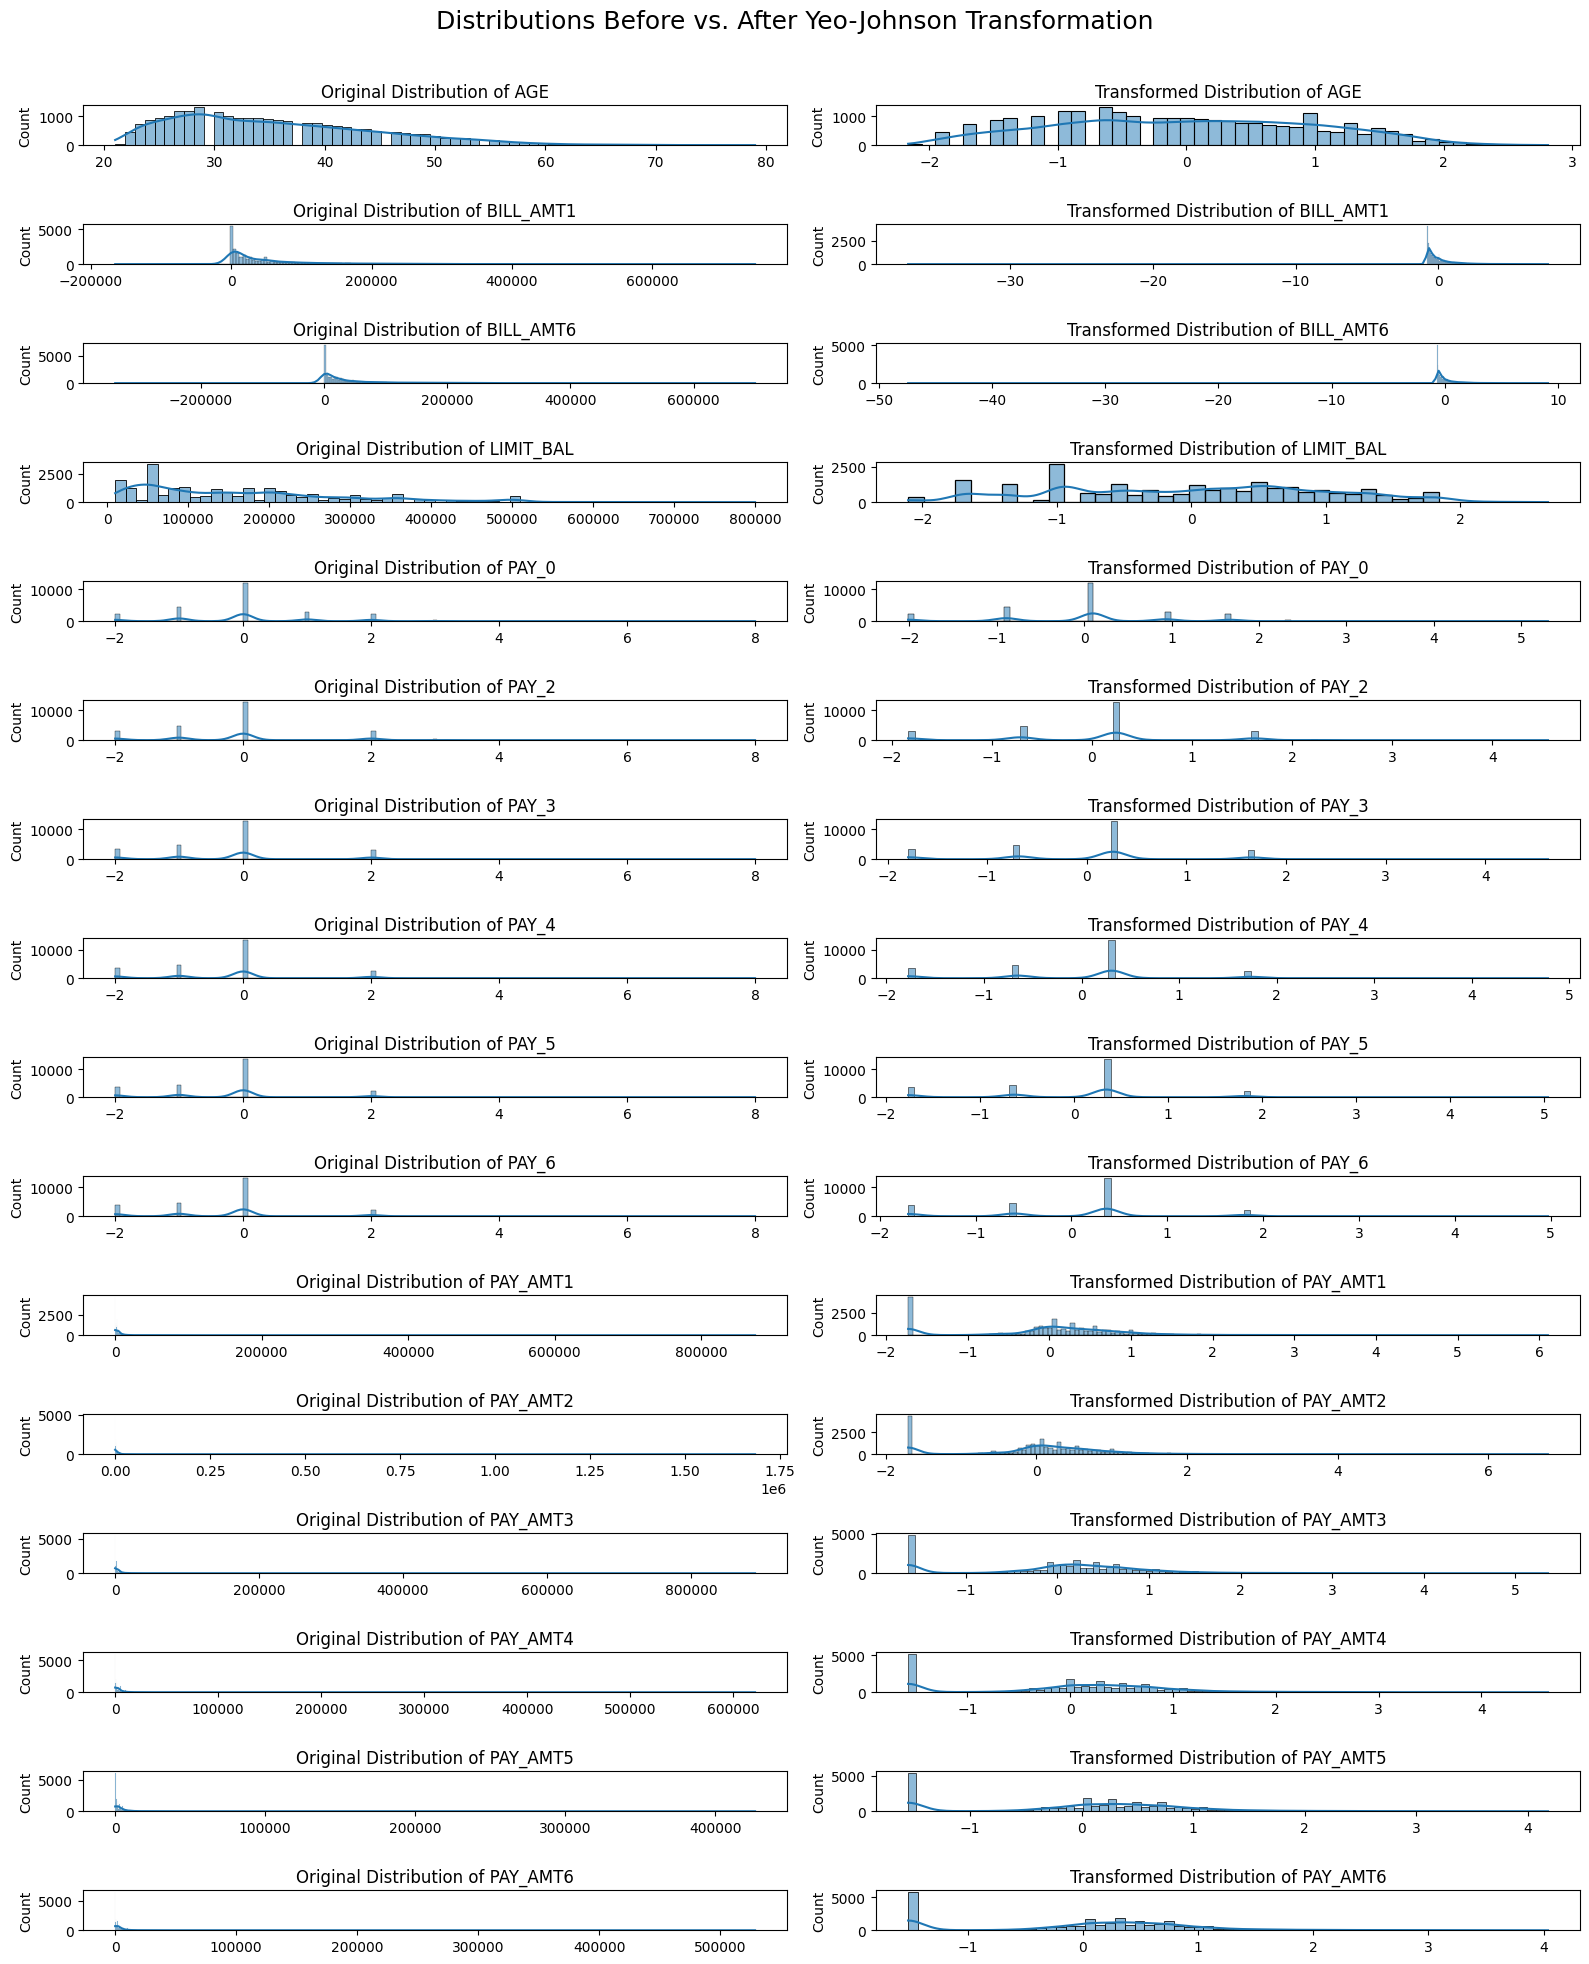

In [28]:
# Create a DataFrame from the processed training data to easily access the transformed columns
# We need to get the new column names created by the OneHotEncoder
ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(nominal_features)
processed_column_names = numerical_and_ordinal_features + ohe_feature_names.tolist()

X_train_processed_df = pd.DataFrame(X_train_processed, columns=processed_column_names)

# Plot the distributions before and after transformation
plt.figure(figsize=(16, 20))
plt.suptitle('Distributions Before vs. After Yeo-Johnson Transformation', fontsize=18)

for i, col in enumerate(numerical_and_ordinal_features):
    # Before transformation
    plt.subplot(len(numerical_and_ordinal_features), 2, 2*i + 1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Original Distribution of {col}')
    plt.xlabel('')

    # After transformation
    plt.subplot(len(numerical_and_ordinal_features), 2, 2*i + 2)
    sns.histplot(X_train_processed_df[col], kde=True)
    plt.title(f'Transformed Distribution of {col}')
    plt.xlabel('')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

**Step 6: Handling Class Imbalance with SMOTE**

You've correctly identified that our target variable is imbalanced. Now that we have preprocessed our data, the next critical step is to balance the training set. We will use the **Synthetic Minority Over-sampling Technique (SMOTE)** to address this.

### Why SMOTE is Essential Here

-   **Prevents Bias**: Without balancing, our model would be heavily biased towards the majority class ('Maintain') and would likely fail to identify customers who are good candidates for a credit limit 'Increase'.
-   **Improves Minority Class Performance**: By creating synthetic examples of the 'Increase' and 'Decrease' classes, SMOTE provides the model with more data to learn the patterns associated with these less frequent outcomes.

### The Correct Workflow

It is absolutely critical to apply SMOTE **only to the training data** and **after** the train-test split. This prevents *data leakage*, where information about the test set bleeds into the training process, leading to overly optimistic and inaccurate performance metrics.

The code below will:
1. Import the `SMOTE` library.
2. Apply it to our processed training data (`X_train_processed`).
3. Show the new, balanced distribution of the classes in our training set.

Original training set shape (24000, 29)
Original training set samples per class [ 5309  6744 11947]

New balanced training set shape (35841, 29)
New balanced training set samples per class [11947 11947 11947]

New balanced training set shape (35841, 29)
New balanced training set samples per class [11947 11947 11947]


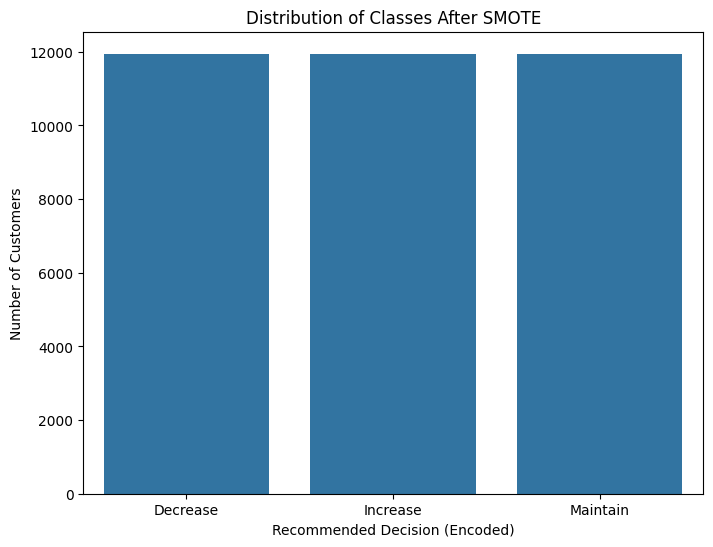

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np

# --- Apply SMOTE to the Training Data ---
print("Original training set shape %s" % str(X_train_processed.shape))
print("Original training set samples per class %s" % str(np.bincount(y_train)))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

print("\nNew balanced training set shape %s" % str(X_train_smote.shape))
print("New balanced training set samples per class %s" % str(np.bincount(y_train_smote)))

# --- Plot the balanced distribution ---
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Distribution of Classes After SMOTE')
plt.xlabel('Recommended Decision (Encoded)')
plt.ylabel('Number of Customers')
# We need to set the tick labels manually as y_train_smote is just numbers
# The mapping is from the LabelEncoder: 0:Decrease, 1:Increase, 2:Maintain
# We need to be careful about the order. Let's check the le.classes_
# le.classes_ would be ['Decrease', 'Increase', 'Maintain']
plt.xticks(ticks=[0, 1, 2], labels=le.classes_)
plt.show()

**Step 7: Model Training, Evaluation, and Hyperparameter Tuning**

Now that our training data is preprocessed and balanced using SMOTE, we can proceed with training and evaluating our models.

This code block will:

Define a dictionary of models to evaluate: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, and XGBClassifier.\
Loop through each model, train it on the **SMOTE-balanced training data**, and print a detailed classification report based on its performance on the original, unbalanced test set.\
Set up a parameter grid for GridSearchCV to tune the XGBClassifier.\
Run the grid search to find the best combination of hyperparameters.\
Evaluate the final, tuned XGBoost model and display its performance with a classification report and a confusion matrix.


In [30]:
# Import models and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [32]:
# --- Part A: Baseline Model Evaluation (Expanded) ---

# Define the models we want to evaluate, now including AdaBoost and SVC
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Support Vector Machine": SVC(random_state=42), # Note: This can be slow on this dataset size
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

# Remember the label mapping: 0: Decrease, 1: Increase, 2: Maintain
target_names = ['Decrease', 'Increase', 'Maintain'] 

print("--- Starting Baseline Model Evaluation (using SMOTE data) ---")

for name, model in models.items():
    # Train the model on the SMOTE-balanced training data
    print(f"Training {name}...")
    model.fit(X_train_smote, y_train_smote)
    
    # Make predictions on the original, unbalanced test set
    y_pred = model.predict(X_test_processed)
    
    # Evaluate and print the results
    print(f"\n----- {name} -----")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))
    print("="*60)

print("\n--- Baseline Evaluation Complete ---")

--- Starting Baseline Model Evaluation (using SMOTE data) ---
Training Logistic Regression...

----- Logistic Regression -----
Accuracy: 0.7017
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.44      0.52      0.48      1327
    Increase       0.73      0.89      0.80      1686
    Maintain       0.85      0.68      0.75      2987

    accuracy                           0.70      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.73      0.70      0.71      6000

Training Decision Tree...

----- Logistic Regression -----
Accuracy: 0.7017
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.44      0.52      0.48      1327
    Increase       0.73      0.89      0.80      1686
    Maintain       0.85      0.68      0.75      2987

    accuracy                           0.70      6000
   macro avg       0.67      0.70      0.68      6000
weighted avg       0.73    

C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [18:18:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



----- XGBoost -----
Accuracy: 0.7907
Classification Report:
              precision    recall  f1-score   support

    Decrease       0.59      0.41      0.49      1327
    Increase       0.83      0.97      0.89      1686
    Maintain       0.82      0.86      0.84      2987

    accuracy                           0.79      6000
   macro avg       0.75      0.75      0.74      6000
weighted avg       0.77      0.79      0.78      6000


--- Baseline Evaluation Complete ---


In [ ]:
# --- Part B: Hyperparameter Tuning with GridSearchCV for XGBoost ---
# This part remains the same, focusing on our best-performing model candidate

print("\n--- Starting Hyperparameter Tuning for XGBoost ---")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'min_child_weight': [1, 3]
}

xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           scoring='accuracy', cv=3, verbose=2, n_jobs=-1)

grid_search.fit(X_train_processed, y_train)

print("\n--- Hyperparameter Tuning Complete ---")
print(f"\nBest Parameters Found: {grid_search.best_params_}")
print(f"Best Cross-validation Accuracy: {grid_search.best_score_:.4f}")


--- Starting Hyperparameter Tuning for XGBoost ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits


C:\Users\abhis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [23:27:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Hyperparameter Tuning Complete ---

Best Parameters Found: {'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Best Cross-validation Accuracy: 0.8206



--- Evaluating the Final Tuned XGBoost Model ---

Tuned XGBoost Accuracy: 0.8212
Tuned XGBoost Classification Report:
              precision    recall  f1-score   support

    Decrease       0.67      0.37      0.48      1327
    Increase       0.86      1.00      0.93      1686
    Maintain       0.83      0.92      0.87      2987

    accuracy                           0.82      6000
   macro avg       0.79      0.76      0.76      6000
weighted avg       0.80      0.82      0.80      6000



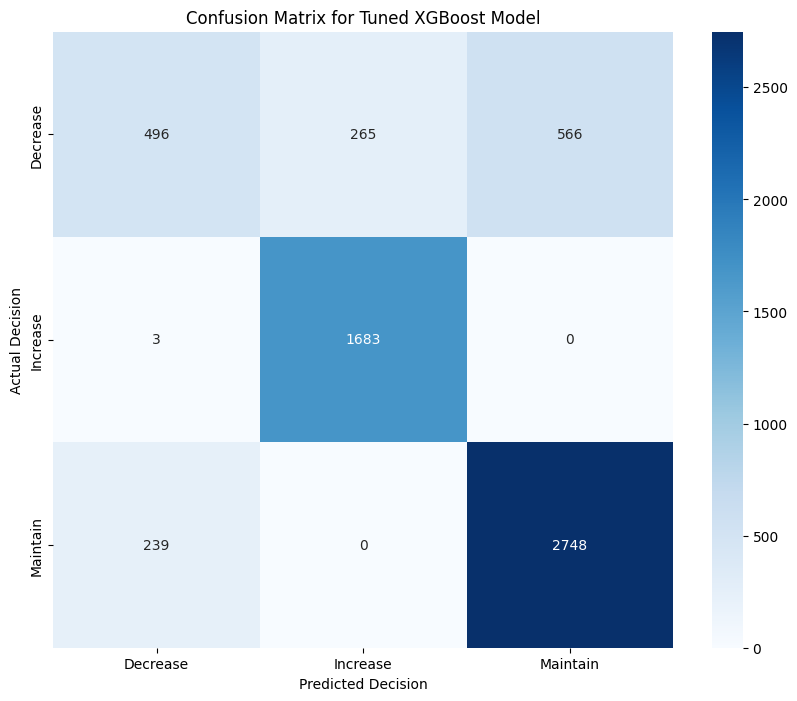

In [ ]:
# --- Part C: Final Evaluation of the Tuned Model ---

print("\n--- Evaluating the Final Tuned XGBoost Model ---")

best_xgb = grid_search.best_estimator_
y_pred_tuned = best_xgb.predict(X_test_processed)

print(f"\nTuned XGBoost Accuracy: {accuracy_score(y_test, y_pred_tuned):.4f}")
print("Tuned XGBoost Classification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=target_names))

# Visualize the final results with a Confusion Matrix
cm = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Tuned XGBoost Model')
plt.xlabel('Predicted Decision')
plt.ylabel('Actual Decision')
plt.show()

**Summary of This Step:**

Baseline Performance: The first part of the code gives you a clear comparison of how different algorithms handle this specific problem. You will likely see that the ensemble methods (RandomForest and XGBoost) perform best.

Optimization: The GridSearchCV part is computationally intensive but crucial. It systematically searches for the hyperparameter combination that yields the best performance, saving you from manual trial-and-error.

Final Results: The final classification report and confusion matrix will show you the real-world performance of your tuned model. You'll be able to see exactly how well it predicts "Increase," "Maintain," and "Decrease" and where it might be getting confused.

After running this, we will have a fully trained and evaluated model for the Dynamic Credit Limit Optimization project.